<div class="alert alert-block alert-info">
<b><big><big><big>Range Prediction</b> <br>
Parquet Reader

<small>
Version 1.3<br>
Created: 23.06.2024  <br>
Modified: 04.09.2024  <br>
William Siegle, Daimler Truck AG

In [1]:
%reset -f

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq 
import warnings
import scipy.stats
from scipy.signal import savgol_filter
import scipy.integrate as integrate
import pickle
from IPython.core.magic import register_cell_magic
#import stumpy
from matplotlib.patches import Rectangle

In [5]:
# ------------ LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  --------------
import sys, os; from pathlib import Path                                                #|
global ROOT, DATA_PATH, IS_NOTEBOOK; IS_NOTEBOOK = True                                 #|
ROOT = Path('..', '..').resolve() if IS_NOTEBOOK else Path('.').resolve()               #|
sys.path.append(os.path.abspath(ROOT))                                                  #|
from data import get_data_path  # paths set in "data/__init__.py"                       #|
DATA_PATH = get_data_path()                                                             #|
print(f"{'-'*60}\n{DATA_PATH}:\t\t{', '.join([_.name for _ in DATA_PATH.glob('*/')])}") #|
print(f"{ROOT}:\t{', '.join([_.name for _ in ROOT.glob('*/')])}")   	                #|
# ----------------------------------------------------------------------------------------

parquet_folder = Path(DATA_PATH, 'processed')
all_files = [os.path.basename(_) for _ in parquet_folder.iterdir() if str(_).endswith(".parquet")]

------------------------------------------------------------
/home/sieglew/MA-Data:		__pycache__, trips_processed_resampled, final, y_true, processed, TripSequences, trips_processed_pickles, final_2, trips_processed_final
/home/sieglew/MA-eR-PINN:	project, ref, test, data, src, .git, archive


In [6]:
@register_cell_magic
def skip(line, cell):   # cells can be skipped by using '%%skip' in the first line
    return

___
___
## 1. Data Import

___
### **Parquet Files**

#### Trip File Selection

In [7]:
# Trip File Selection
vehicle_selection = '13'
trip_selection = ['207_2']

In [8]:
parquet_selection = []  #if 'parquet_selection' not in globals()
    
for t in trip_selection:
    V_files = [f for f in all_files if 'V' + vehicle_selection in f]
    for f in V_files:
        if ('V' + vehicle_selection + '_trip' + t + '.parquet') in f:
            parquet_selection.append(f)

In [9]:
parquet_selection.sort()
print(parquet_selection)
print()

df = pd.read_parquet(Path(parquet_folder, parquet_selection[0]))
df.sort_index(axis=1, inplace=True)
df.info()

['v_id983V13_trip207_2.parquet']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9505 entries, 0 to 9504
Columns: 114 entries, accelpdlposn_cval to vehweight_cval_pt
dtypes: datetime64[ns](1), float64(112), int64(1)
memory usage: 8.3 MB


___
### **Signal Overview and Classification**

#### Preselect important signals

In [10]:
signal_names = __builtins__.list(df.columns)
signal_names.sort()

selected_columns = [
    "hv_bat_dc_volt_cval_bms1",
    "hv_curr_cval_dcl1",
    "airtempoutsd_cval_cpc",
    "accelpdlposn_cval",
    "hv_ptc_cabin1_pwr_cval",
    "hv_batcurr_cval_bms1",
    "bs_brk_cval",
    "brktempra_cval",
    "hv_batmaxdischrgpwrlim_cval_1",
    "hv_batmaxchrgpwrlim_cval_1",
    "hv_batmomavlchrgen_cval_bms1",
    "hv_batmomavldischrgen_cval_1",
    "hv_chrgpwr_ecpc_cval",
    "hv_bat_dc_momvolt_cval_bms1",
    "hv_pwr_cval_dcl1",
    "txoiltemp_cval_tcm",
    "oiltemp_ra_cval",
    "hv_bat_soh_cval_bms1",
    "meanmoduletemperature_bms01",
    "brktempfa_cval",
    "hv_bat_soc_cval_bms1",
    "hv_batpwr_cval_bms1",
    "actualspeed_pti1",
    "actualspeed_pti2",
    "vehspd_cval_cpc",
    "rmsmotorcurrent_pti2",
    "rmsmotorcurrent_pti1",
    "actualdcvoltage_pti1",
    "powerstagetemperature_pti1",
    "edrvspd_cval",
    "motortemperature_pti1",
    "actualtorque_pti1",
    "actdrvtrnpwrprc_cval",
    "epto_pwr_cval",
    "cc_setspd_cval",
    "maxrecuppwrprc_cval"
]

# add more signal variables to selection:
selected_columns.extend(["altitude_cval_ippc",
                         "bs_roadincln_cval",
                         "grocmbvehweight_cval",
                         "plugchrg_stat",
                         "roadgrad_cval_pt",
                         "hirestotalvehdist_cval_icuc"])

selected_columns.sort()

#### Signal Grouping

> Group all available selected signals by domain/type:  
> Note: this dict also contains empty signals (containig NaNs only)

In [11]:
signal_groups = {
    # time, GPS, Route Data from Map:
    "time_sig":     ["signal_time", "signal_ts"],
    "gps_sig":      ["latitude_cval_ippc", "longitude_cval_ippc"],
    "road_sig":     ["altitude_cval_ippc","roadgrad_cval_pt", "bs_roadincln_cval","maproadgrad_cval"],

    # Environmental and HVAC Temperatures:
    "airtemp_sig":  ["airtempinsd_cval_hvac", "airtempinsd_rq", "airtempoutsd_cval_cpc", "airtempoutsd_cval_sca", "ambtemp_cval_pt"],

    # Vehicle weight measurements
    "weight_sig":   ["grocmbvehweight_cval" ,"vehweight_cval_pt"],

    # vehicle movement and driver operations:
    "motion_sig":   ["hirestotalvehdist_cval_icuc","hirestotalvehdist_cval_cpc","odometer","vehspd_cval_cpc"],
    "driver_sig":   ["accelpdlposn_cval", "bs_brk_cval"],

    # drivetrain related
    "mot_sig":      ["actualspeed_pti1","actualspeed_pti2","actualtorque_pti1","actualtorque_pti2","edrvspd_cval","emot_pwr_cval","motortemperature_pti1",
                     "motortemperature_pti2","rmsmotorcurrent_pti1","rmsmotorcurrent_pti2"],
    "drivetrain_sig":   ["actdrvtrnpwrprc_cval", "maxrecuppwrprc_cval", "maxtracpwrpct_cval"],
    "transmission_sig": ["currgr_stat_edcu","grshift_stat_pt", "selgr_rq_pt"],

    # hv battery and battery modules/cells related
    "bat_sig": ["hv_bat_dc_maxvoltlim_cval","hv_bat_dc_minvoltlim_cval","hv_bat_dc_momvolt_cval_bms1","hv_bat_dc_volt_cval_bms1","hv_bat_intres_cval_bms1",
                "hv_bat_soc_cval_bms1","hv_bat_soh_cval_bms1","hv_batcurr_cval_bms1","hv_batisores_cval_e2e","hv_batlinkvoltage_sc01","hv_batmaxchrgpwrlim_cval_1",
                "hv_batmaxdischrgpwrlim_cval","hv_batmaxdischrgpwrlim_cval_1","hv_batmomavlchrgen_cval_bms1","hv_batmomavldischrgen_cval_1","hv_batpwr_cval_bms1",
                "linkvoltage_bms05","maxbrickvoltage_bms01","stringvoltage_bms01"],
    "bat_cell_sig": ["hv_batavcelltemp_cval_bms1","hv_bathighcelltemp_cval_bms1","hv_batlowcelltemp_cval_bms1","maxmoduletempindex_bms01",
                     "meanmoduletemperature_bms01","minmoduletempindex_bms01"],

    # power electronics, charging and control
    "electronics_sig":  ["hv_ptc_cabin1_pwr_cval","hv_ptc2_pwr_cval","pt4_dcb_hvdc_power_max_st3"],
    "inverter_sig":     ["actualdcvoltage_pti1","actualdcvoltage_pti2","inv1_curr_cval_api1","inv1_pwr_cval_api1","inv1_pwr_cval_api3","inv1_spd_cval_api1",
                         "inv2_curr_cval_api2","inv2_pwr_cval_api2","inv2_spd_cval_api2","powerstagetemperature_pti1","powerstagetemperature_pti2"],
    "converter_sig":    ["hv_curr_cval_dcl1","hv_dclink_volt_cval_dcl1","hv_pwr_cval_dcl1","lv_conv_dc_momvolt_cval_dcl1","lv_conv_voltdmd_e2e_dcl1",
                         "lv_convcurr_cval_dcl1","lv_convmaxcurr_cval_dcl1","lv_convpwr_cval_dcl1"],
    "brc_sig":          ["brc_stat_brc1","brc_stat_brc2", "hv_dclink_volt_cval_brc", "hv_dclink_volt_cval_brc2", "currpwr_contendrnbrkresist_cval",
                         "currpwr_contendrnbrkresist2", "currtmp_brkresist1int_cval", "currtmp_brkresist2int_cval","dsrdpwr_contendrn_cval",
                         "dsrdpwr_contendrn2_cval", "maxpwr_contendrnbrkresist_cval", "maxpwr_contendrnbrkresist2"],
    "charge_sig":       ["chargestate","chrgcoupproxydet_stat","hv_chrgpwr_ecpc_cval","plugchrg_stat"],
    "control_sig":      ["cc_actv_stat","cc_setspd_cval","ignsw_stat_sca"],

    # auxiliary consumers
    "aux_pto_sig":      ["elcomp_pwrcons_cval","epto_pwr_cval"],

    # temp. and other
    "temp_sig":         ["brktempfa_cval", "brktempra_cval","oiltemp_ra_cval","txoiltemp_cval_tcm","pt4_dcb_temp1_st3","pt4_dcb_temp2_st3"],
}

___
### **Data Preprocessing**


#### Find empty signals, constant and missing values

> dropping all empty signals from DataFrame

In [12]:
signal_only_nans = list(df.columns[np.array(df.isnull().all())])
df.drop(columns = signal_only_nans, inplace=True)

> manually specify other signals to drop:

In [13]:
for rmv in ['diff','vehicle_id']:
    if rmv in df.columns:
        df.drop(columns = rmv, inplace=True)

> update signal_groups dictionary and delete empty keys:

In [14]:
for group in list(signal_groups.keys()):
    sig_list = signal_groups[group]
    for sig in sig_list:
        if sig not in list(df.columns):
            signal_groups[group].remove(sig)

if any([not signal_groups[g] for g in list(signal_groups.keys())]):
    for key in [list(signal_groups.keys())[np.where([not signal_groups[g] for g in list(signal_groups.keys())])[0][0]]]:
        del signal_groups[key]

#### Remove Abrupt Drops from GPS interruptions

> Repairing Sections with abrupt drops to 0, that possibly might indicate a GPS signal/measurement error

In [15]:
# identify simultaneous 0 values in all GPS related Signals (Lat/Long and Altitude)
gps_drop = np.where((df[['latitude_cval_ippc','longitude_cval_ippc','altitude_cval_ippc']].values < 0.1).any(1))[0]

# also add neighboring time steps:
gps_drop = list(set(list(gps_drop + 1) + list(gps_drop - 1) + list(gps_drop)))

if len(gps_drop) > 0:
    df.loc[gps_drop,['latitude_cval_ippc','longitude_cval_ippc','altitude_cval_ippc']]  = np.nan
    print('GPS interruptions removed.')

GPS interruptions removed.


#### Data Filling 

> find signals with missing values:

In [16]:
signal_with_nans = list(df.columns[np.array(df.isnull().any())])

> Applying forward and backwards filling for signals with max. 25% missing values:

In [17]:
for sig in signal_with_nans:
    # consider only signals that have less than 25 % NaNs:
    if df[sig].isnull().mean()*100 < 100:
        #df[sig] = df[sig].ffill().bfill()
        df[sig] = df[sig].fillna(df[sig].median())
print("All signal gaps removed with forward/backward filling.")

All signal gaps removed with forward/backward filling.


> Collect incomplete signals with more than 25% NaNs:

In [18]:
signal_with_nans = list(df.columns[np.array(df.isnull().mean() * 100 > 25)])

print("Incomplete or empty Signals (>25% NaNs):")
print("-"*50)
for sig in signal_with_nans + signal_only_nans:
    print(sig)

Incomplete or empty Signals (>25% NaNs):
--------------------------------------------------
chrgcoupproxydet_stat
epto_pwr_cval
hv_batmaxdischrgpwrlim_cval
hv_ptc2_pwr_cval
inv1_curr_cval_api1
inv1_pwr_cval_api1
inv1_pwr_cval_api3
inv1_spd_cval_api1
inv2_curr_cval_api2
inv2_pwr_cval_api2
inv2_spd_cval_api2
odometer
signal_date
vehicle_id


> find signals with constant values:

In [19]:
constants = {}
for col in df.columns:
    if len({x for x in df[col] if x==x}) == 1:
        constants[col] = df[col][0]

for c in constants.keys():
    print(c," = ", constants[c])
    
#df.drop(columns = list(constants.keys()), inplace=True)

cc_actv_stat  =  0.0
cc_setspd_cval  =  50.0
chargestate  =  0.0
hv_bat_dc_minvoltlim_cval  =  331.90000000000003
hv_bat_intres_cval_bms1  =  0.0162
hv_bat_soh_cval_bms1  =  97.0
hv_chrgpwr_ecpc_cval  =  0.0
maxrecuppwrprc_cval  =  100.0
maxtracpwrpct_cval  =  85.0
plugchrg_stat  =  0.0
pt4_dcb_hvdc_power_max_st3  =  55.0


___
### **Specific Signal Adjustments: Conversion, Filtering and Smoothing**

#### Time

> correct the timestamp data with factor 1000 if datetimes are not realistic:

In [20]:
from datetime import datetime

if max(df.signal_time).year < 2000:
    df.signal_time = pd.to_datetime(df.signal_ts * (10**3))

if max(df.signal_time).year > 2024:
    warnings.warn("Timestamp signals might be incorrect! Please check.")

In [21]:
time = pd.DataFrame(np.array((df.signal_time - df.signal_time[0]).dt.seconds))    # TIME since trip Start [s] --> corresponding to time series indices
time_unix = df.signal_time  # UNIX TIME (starting 1970) [s]

#### Distance

In [22]:
dist = ((df.hirestotalvehdist_cval_icuc - df.hirestotalvehdist_cval_icuc[0]) * 1000).round(3)   # MILEAGE since trip Start [m]

#### Vehicle Motion

In [23]:
speed = df.vehspd_cval_cpc/3.6                                  # VEHICLE SPEED [m/s]
dist_diff = np.insert(np.diff(dist),0,0)                        # MILEAGE DIFFERENTIAL (distance to last data point) [m/s] 

>calculate vehicle acceleration by using discrete differences  
and applying a smoothing filter (Savitzky-Golay filter with small window)

In [24]:
aa = np.diff(speed, prepend = speed[0])

In [25]:
accel = pd.DataFrame(savgol_filter(np.diff(speed, prepend = speed[0]),10,1))      # LONGITUDINAL VEHICLE ACCELERATION [m/s^2]    
accel = pd.DataFrame(np.diff(speed, prepend = speed[0]))

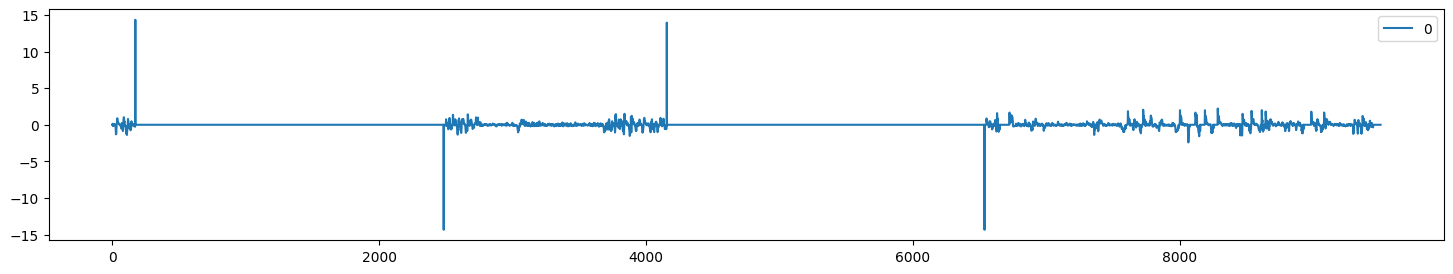

In [26]:
_ = pd.DataFrame(accel).plot(figsize=(18, 3), subplots=True)

#### Location

In [27]:
gps_pos = pd.DataFrame(tuple(zip(df['latitude_cval_ippc'], df['longitude_cval_ippc'])))

#### Road Gradient

In [28]:
alt = df.altitude_cval_ippc                               # ALTITUDE [m]  

> from Brake Systems-Signal (possibly contains offset of 0.4 %)

In [29]:
road_grad = pd.DataFrame(savgol_filter(df.bs_roadincln_cval, 10, 3))    # ROAD GRADIENT [%] = [tan(alpha) * 100]       

> Alternatively, calculate road gradient from altitude with respect to distance signals: alt_grad = d_alt/d_dist  
For this purpose, only non-zero values of d_dist can be considered

In [30]:
alt_grad_pre = np.gradient(np.array(alt[dist_diff > 0]),np.array(dist[dist_diff > 0])) * 100

# to get the gradient over time, map previously calculated values to time series at correct indices:
alt_grad = np.zeros(len(alt))
count = 0
for idx in np.where(dist_diff > 0)[0]:
    alt_grad[idx] = alt_grad_pre[count]
    count +=1

# apply smoothing filter:
alt_grad = pd.DataFrame(savgol_filter(alt_grad, 10, 3))       # ROAD GRADIENT [%] = [tan(alpha) * 100]        # calculated from altitude over distance


#axs = pd.DataFrame(alt_grad)[4000:5000].plot(figsize=(18, 3), subplots=True)

#### Air Temperature

In [31]:
amb_temp = pd.DataFrame(savgol_filter(df.ambtemp_cval_pt, 100, 3))    # ambient temperature [°C]

#### Battery

In [32]:
soc = df.hv_bat_soc_cval_bms1/100                  # Battery State of Charge [-]

if "hv_bat_soh_cval_bms1" in constants.keys():
    soh = constants["hv_bat_soh_cval_bms1"]/100
else:
    soh = np.mean(df.hv_bat_soh_cval_bms1)/100          # Battery State of Health [-] (constant)
    print('Battery State of health is changing during trip.')   

In [33]:
bat_pwr = df.hv_batpwr_cval_bms1                # Battery Power [kW]  = df.hv_bat_dc_momvolt_cval_bms1  *  df.hv_batcurr_cval_bms1  = U*I

bat_mom_en = df.hv_batmomavldischrgen_cval_1    # Momentary Available discharge energy [kWh]

bat_cap_total = np.mean(bat_mom_en + df.hv_batmomavlchrgen_cval_bms1)  # Total battery capacity (constant) [kWh]
# calculated by mean of sum of momentary available charge and discharge energies

#### Electrical Motors & Drivetrain

In [34]:
mot_1_speed = df.actualspeed_pti1               # Motor 1 Speed [rpm]
mot_1_torque = df.actualtorque_pti1             # Motor 1 Torque [Nm] (or [%] ?)

mot_2_speed = df.actualspeed_pti1               # Motor 2 Speed [rpm]
mot_2_torque = df.actualtorque_pti1             # Motor 2 Torque [Nm] (or [%] ?)

mot_pwr = df.emot_pwr_cval                      # Electrical power of motors (combined) [kW]

___
### **Vehicle Parameters**

#### Available Truck Parameter Data Import

> import vehicle parameters, specified in file 'VehModel.py':

In [35]:
from src.physics_model.VehModel import CreateVehicle

V = CreateVehicle(vehicle_selection)

print('Imported Vehicle Parameters:')
print("-"*50)
for prm in sorted(V.prm.keys()):
    print(prm," = ", V.prm[prm])

Imported Vehicle Parameters:
--------------------------------------------------
base_weight_kg  =  10000
c_w_a  =  4.96
cooling_body  =  1
gear_ratio  =  15.1
hv_batt_installed_capacity  =  336
hv_batt_physical_low_lmt  =  5
hv_batt_physical_up_lmt  =  97
hv_batt_total_capacity  =  325.6
hv_batt_useable_capacity  =  309.12
max_weight_kg  =  27000
num_axles  =  3
num_batt_packs  =  3
num_driven_axles  =  1
num_emotors  =  2
speed_limit_cpc  =  89
speed_limit_tol  =  10
srv_brk_energy_fac  =  0.02
tire_radius  =  0.492
tire_roll_res_coeff  =  0.0055
veh_height  =  4.0
veh_length  =  10.0
veh_prm  =  13
veh_width  =  2.55


#### Weight Estimation

In [36]:
vehweight = df.vehweight_cval_pt*1000  # weight (t) (PT) [kg]
grocmb = df.grocmbvehweight_cval       # gross combination weight (t) [kg]

> The correct estimation of the vehicle weight is crucial for estimating the resistance forces in the following sections.
> However the weight of the whole truck (including load) can only be roughly estimated by the intertial sensors depending mostly on the
> longitudinal dynamic behaviour of the vehicle. This makes it difficult to determine wether the truck is really changing its mass during the 
> trip (increasing/decrasing load charge or trailer attachment) or only has variances in the measurement due to unfavorable driving situations. 

> In general the weight of the vehicle can be considered as constant, if the charges remains unchained and no trailer is attached/detached.
> Since there are two significant weight information signals, they can be compared:

'vehweight_cval_pt' (acc: 1000 kg)  
'grocmbvehweight_cval' (acc: 10 kg)

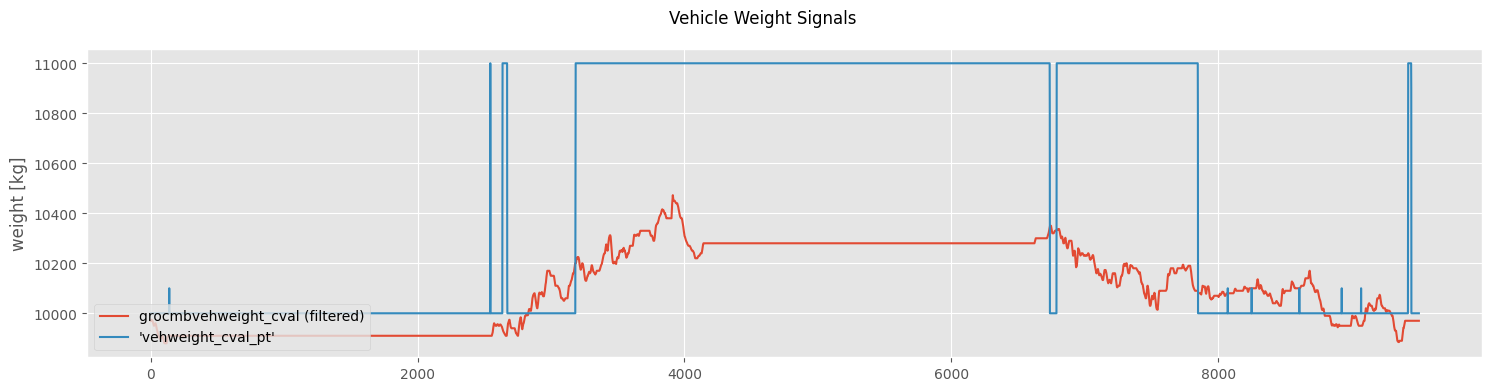

In [37]:
fig , axs = plt.subplots(1, sharex=True,figsize=(18, 4)) #gridspec_kw={'hspace': 0}
plt.suptitle('Vehicle Weight Signals', fontsize='12')
axs.set_ylabel('weight [kg]', fontsize='12')

if 'grocmbvehweight_cval' not in signal_only_nans:
    m_grocmb = savgol_filter(pd.DataFrame(grocmb).to_numpy()[:,0], 10,1)
    axs.plot(m_grocmb, label="grocmbvehweight_cval (filtered)")

if 'vehweight_cval_pt' not in signal_only_nans:
    axs.plot(vehweight, label="'vehweight_cval_pt'")

axs.legend(loc = "lower left")

> For the estimation of the total vehicle mass, it is assumed that the gross combination weight estimate is improving over
distance and thus becoming more accurate during the trip (assuming a real constant mass). The signal value is therefore weighted with the already driven distances,
putting more impact on the latest calculated values, similar to converging against the correct value with increasing distance.

> If this option is not available, the weight is derived from the discrete 'vehweight_cval_pt'-measurement instead, which is not based on dynamic calculations and has a accuracy of 1000 kg steps only.

In [38]:
try:
    weight_est_mean = sum(np.multiply(grocmb,dist))/sum(dist)       # approximated vehicle weight [kg]

# if 'grocombvehweight' is empty:
except:
    weight_est_mean = np.mean(vehweight)

> Now the question is whether the real vehicle mass can be assumed to remain constant for the trip duration, or the charged load is indeed
changing at some point in the series, which requires a time variant weight signal for the correct range prediction?

___
### **Conversion and Save**

> Concatenate Time Series Data to new DataFrame:

In [39]:
T = pd.concat([time, time_unix, dist, speed, accel, gps_pos, alt, road_grad, alt_grad, amb_temp,soc,bat_pwr,bat_mom_en, 
                 mot_1_speed,mot_1_torque,mot_2_speed,mot_2_torque,mot_pwr, vehweight, grocmb], axis = 1)

T.columns = ['t',                       # Time since Trip Start ,[s]
             'date',                    # Date-time stamp
             'dist',                    # Distance since Start, [m]
             'speed',                   # Speed, [m/s]
             'accel',                   # Acceleration, [m/s²]
             'lat','long',              # GPS-Coordinates (Latitude, Longitude)
             'alt',                     # Altitude, [m]
             'road_grad',               # Road Slope, [%]
             'alt_grad',                # Road Slope (calculated from Altitude profile), [%]
             'amb_temp',                # Ambient Air Temperature, [°C]
             'soc',                     # Battery SOC, [-]
             'bat_pwr',                 # Battery Power, [kW]
             'bat_mom_en',              # Momentary Available discharge energy [kWh]
             'Mot1_speed',              # Motor 1 Speed, [rpm]
             'Mot1_torque',             # Motor 1 Torque, [Nm]
             'Mot2_speed',              # Motor 2 Speed, [rpm]
             'Mot1_torque',             # Motor 2 Torque, [Nm]
             'Mot_pwr',                 # Total Motor Power, [kW]
             'vehweight',               # Vehicle Weight (PT), [kg]
             'grocmb'                   # Vehicle Weight (GroCmb), [kg]
             ]               

> Concatenate Constant Value Data to new DataFrame:

In [40]:
C = {}
C = dict((k,eval(k)) for k in ["weight_est_mean","soh","bat_cap_total"])
C = {**C,**constants}

In [41]:
%%skip

file_code = parquet_selection[0][7:-8]

with open(f'{file_code}.pickle', 'wb') as handle:
    pickle.dump([T,C,V.prm,df], handle, protocol=pickle.HIGHEST_PROTOCOL)

___
### **PLOTS**

In [42]:
%%skip

# plot all signals
for sig in signal_names:
    if sig in df.columns:
        _ = df[sig].plot(figsize=(18, 3), subplots=True, title = sig)
        plt.show()

time_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


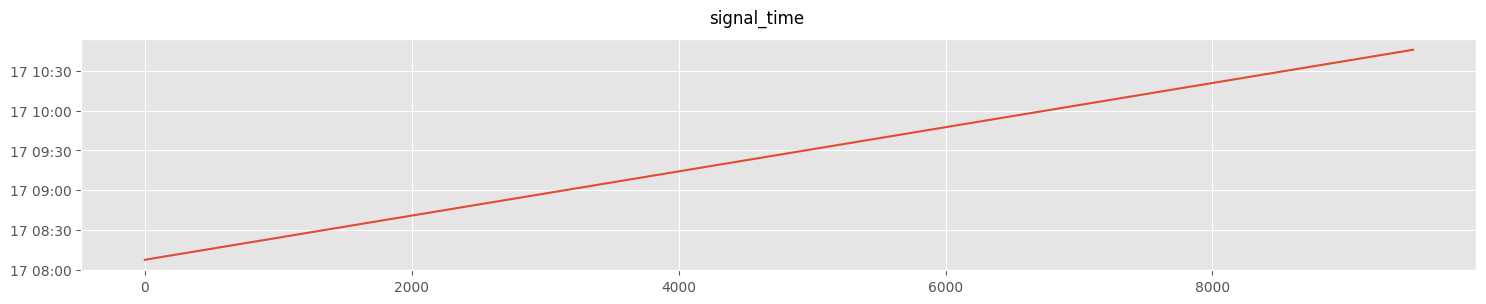

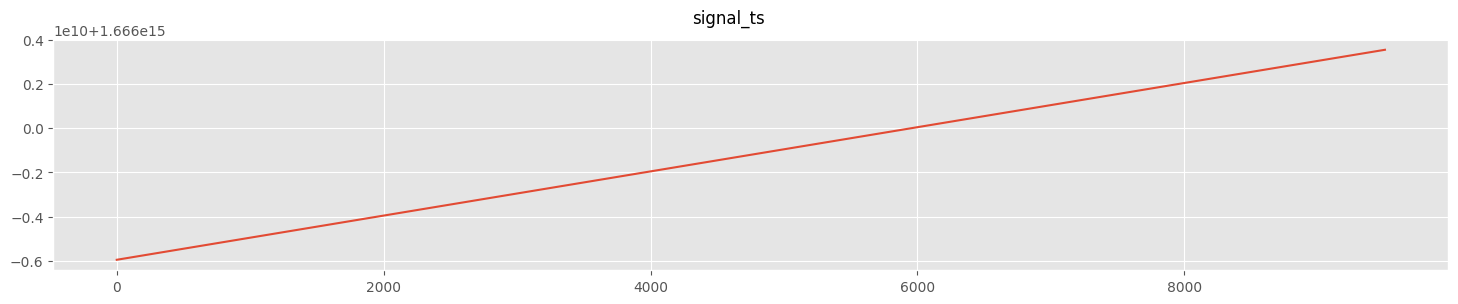

gps_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


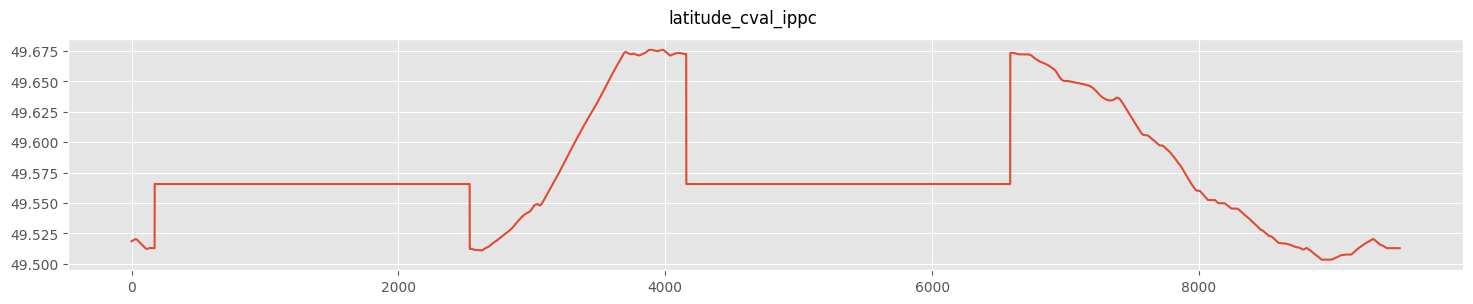

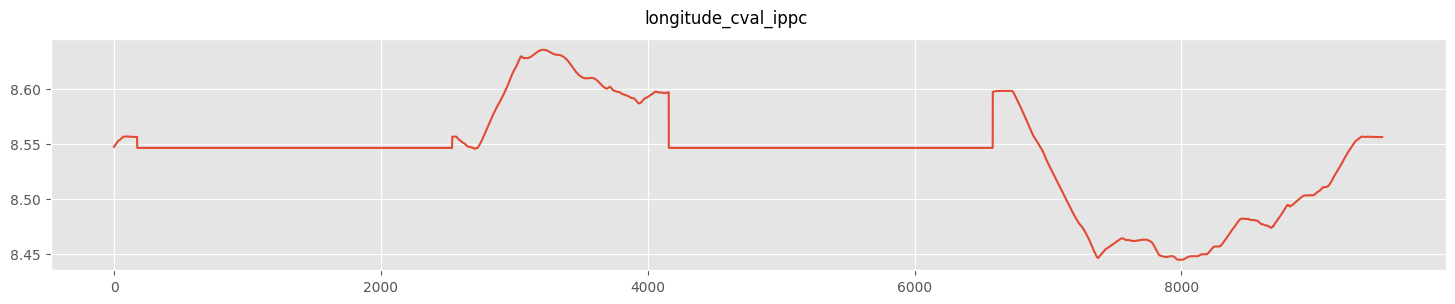

road_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


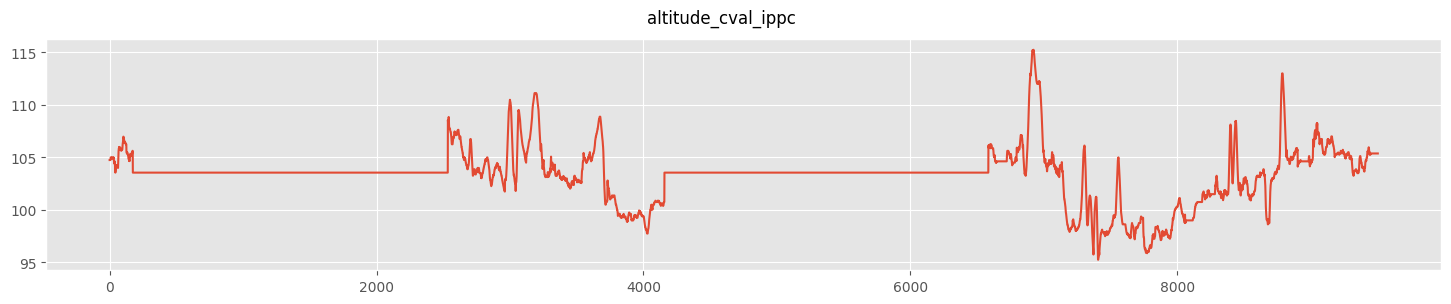

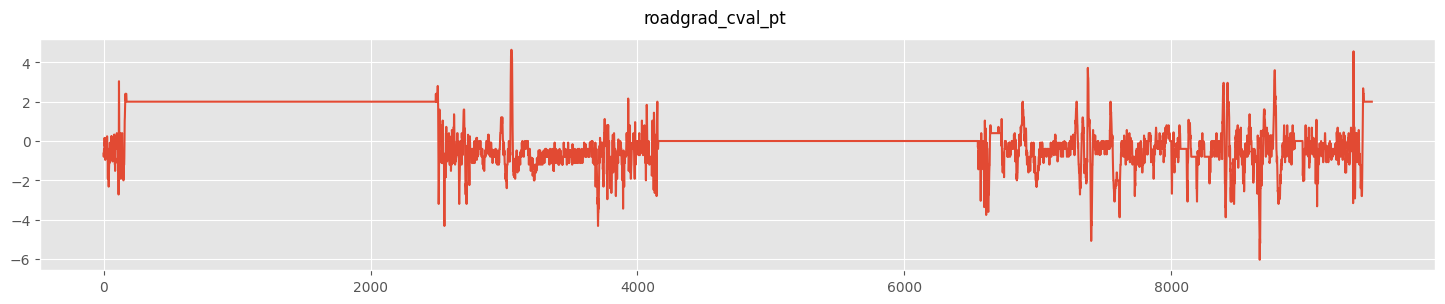

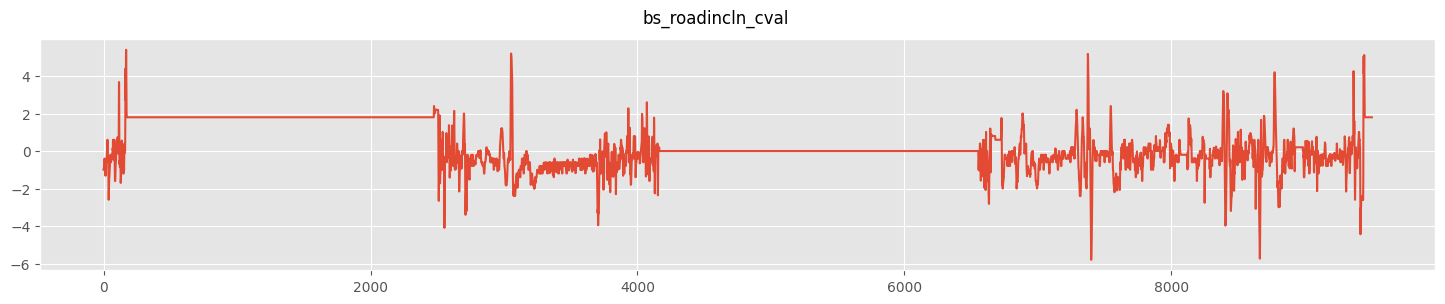

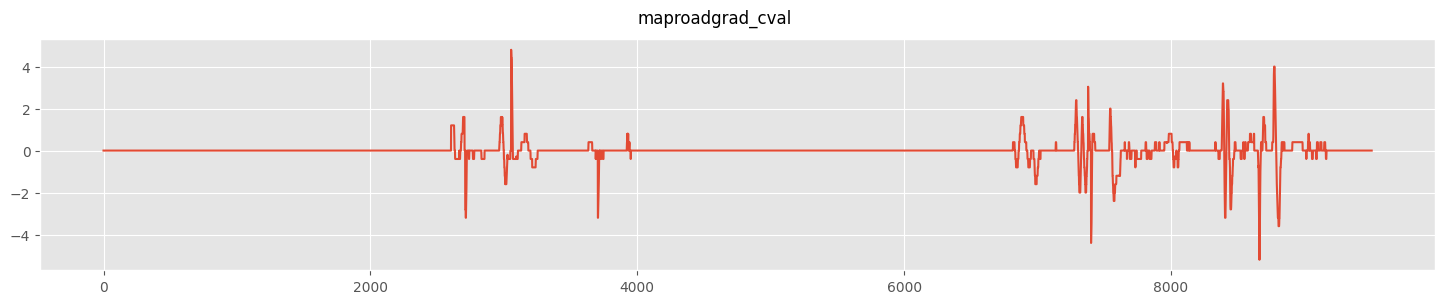

airtemp_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


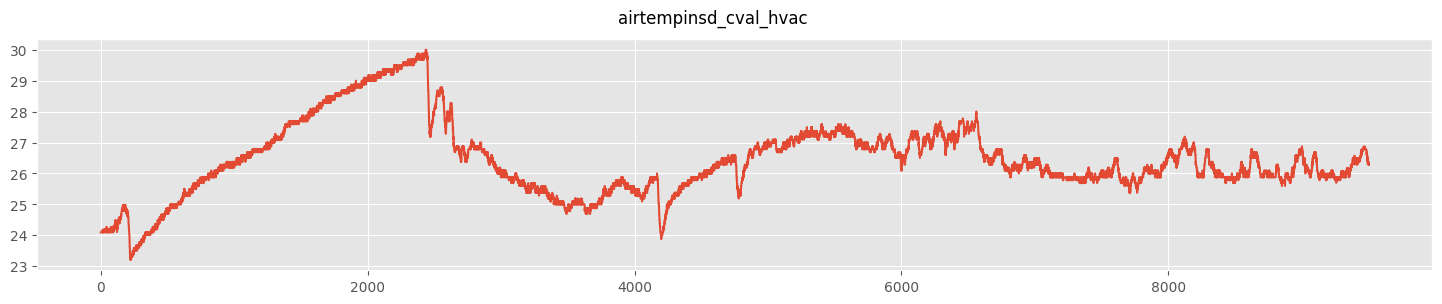

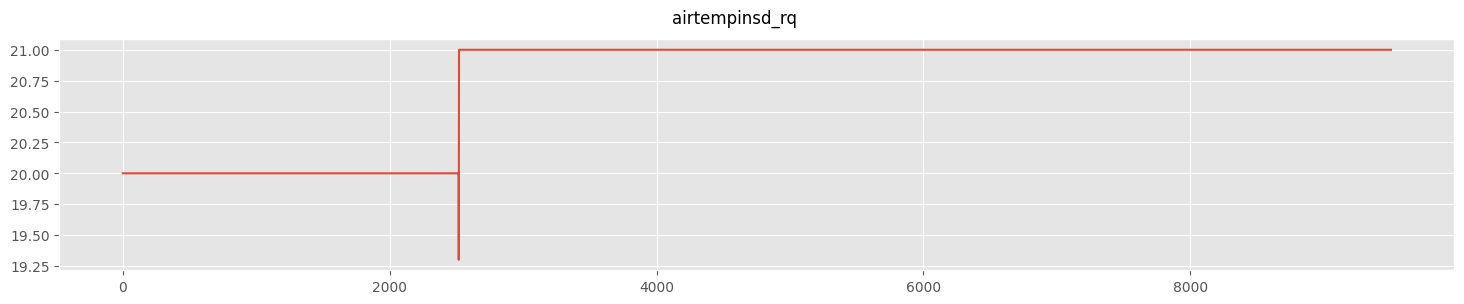

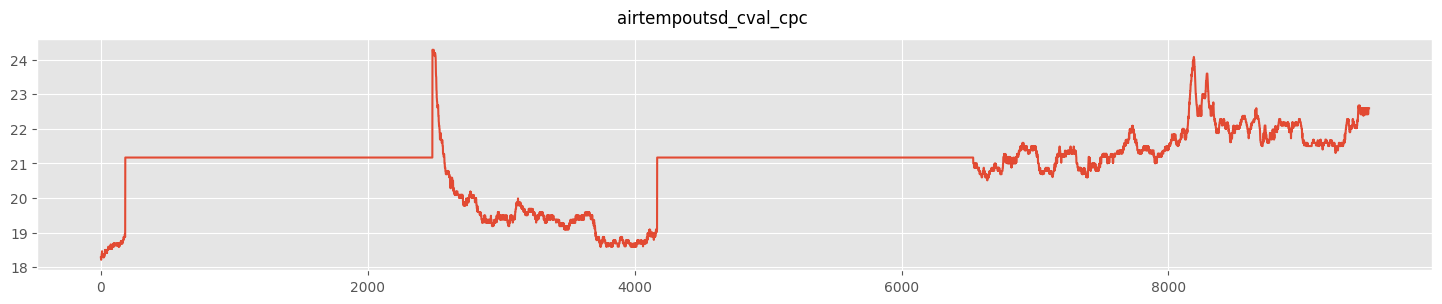

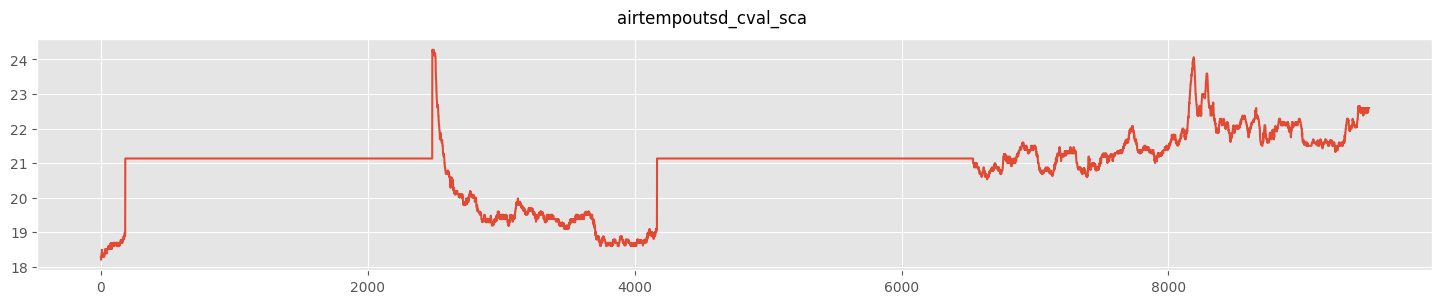

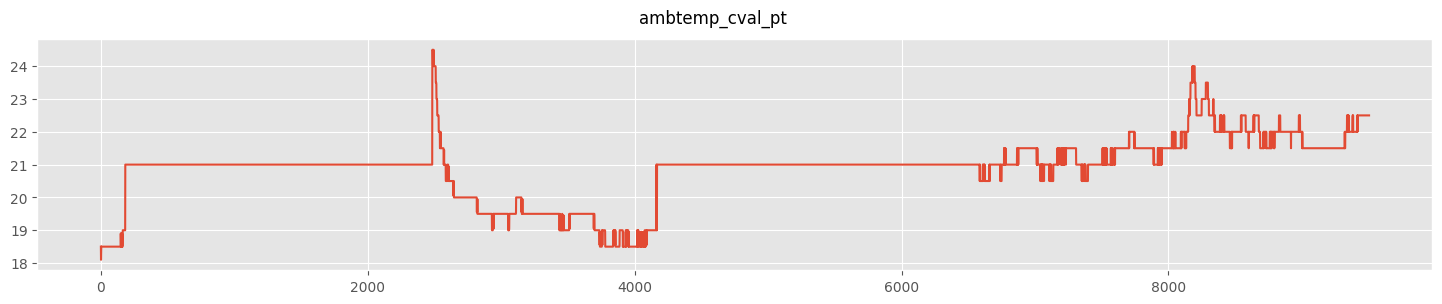

weight_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


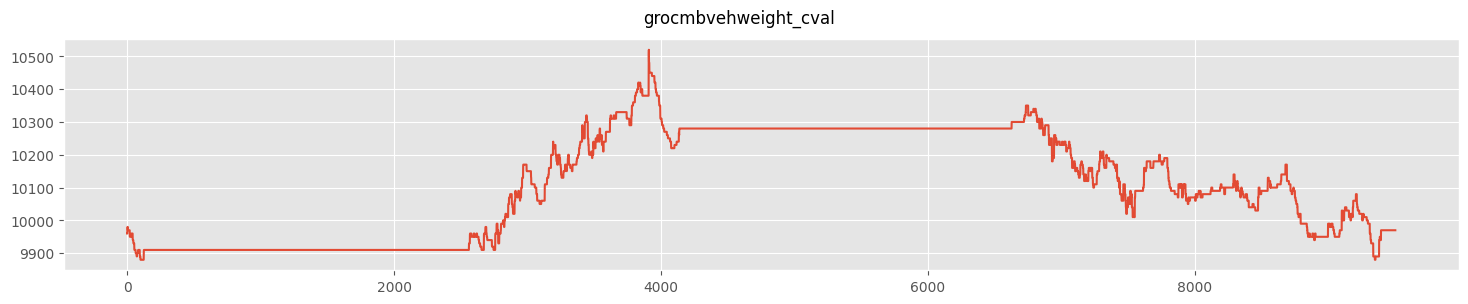

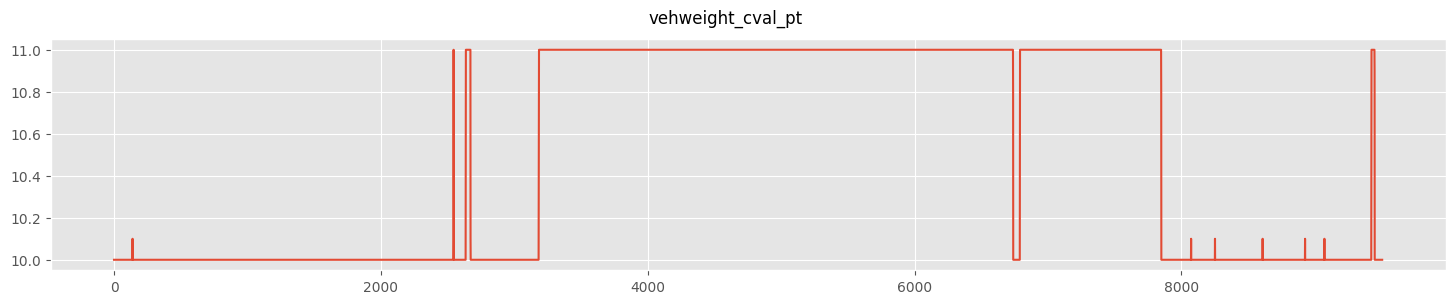

motion_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


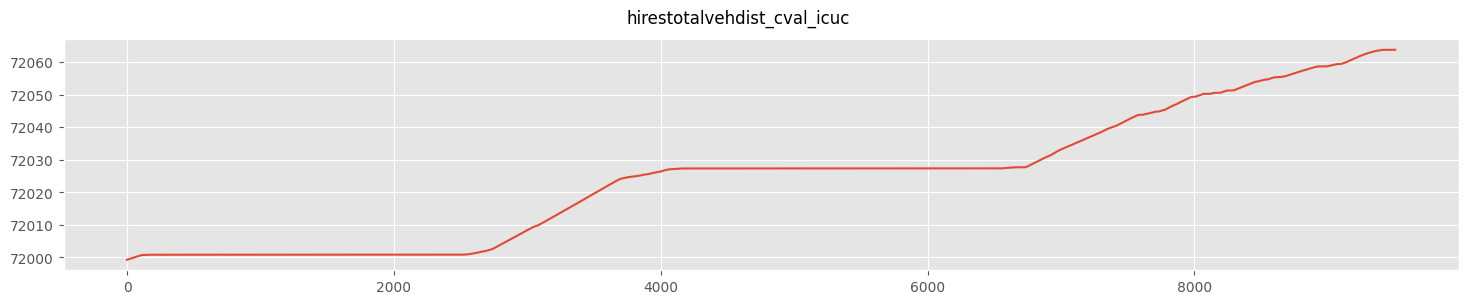

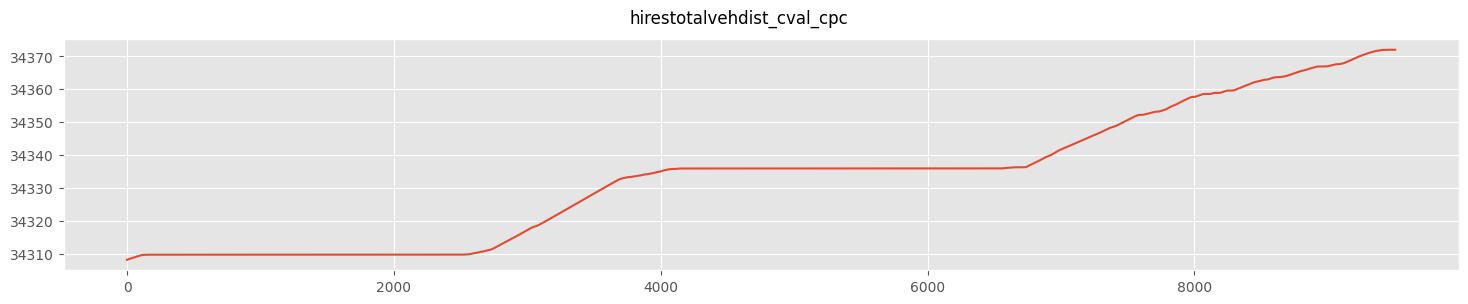

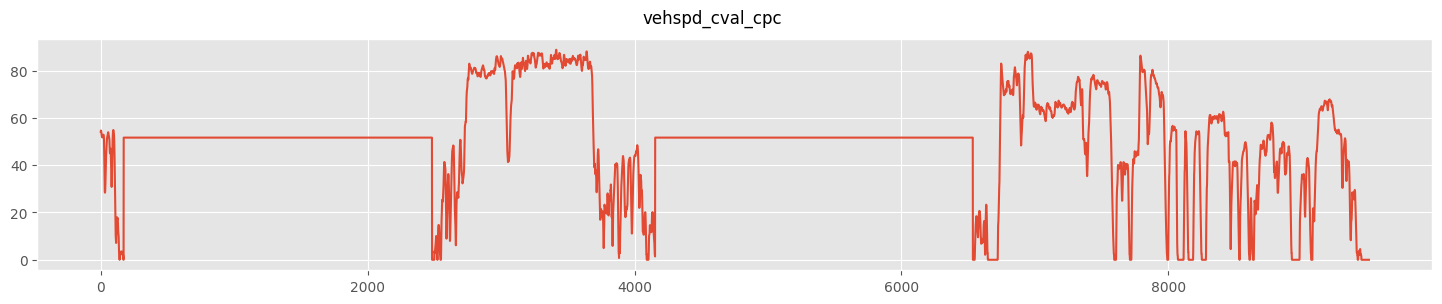

driver_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


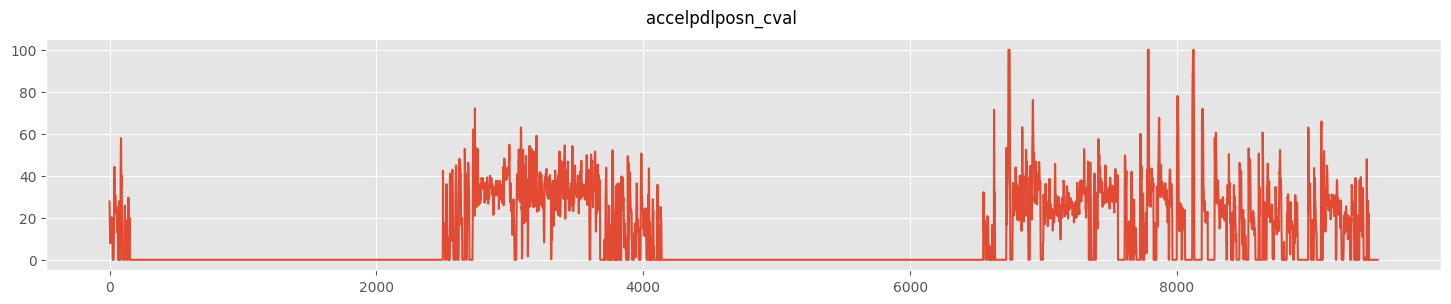

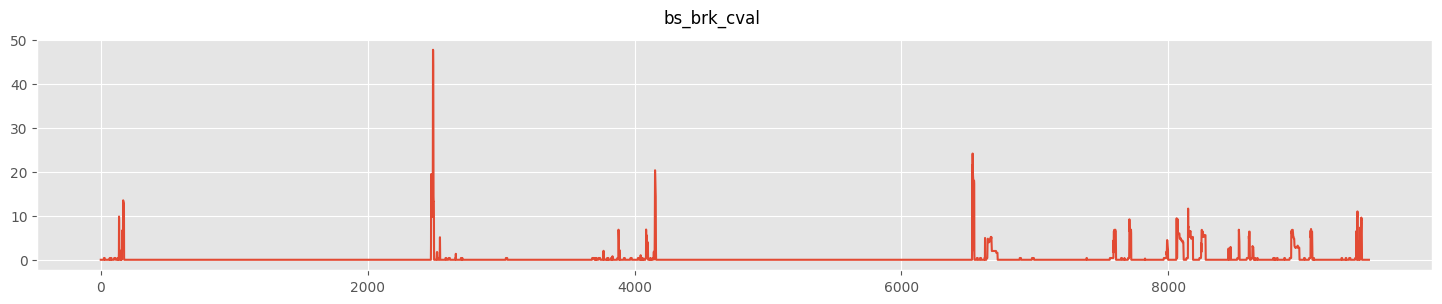

mot_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


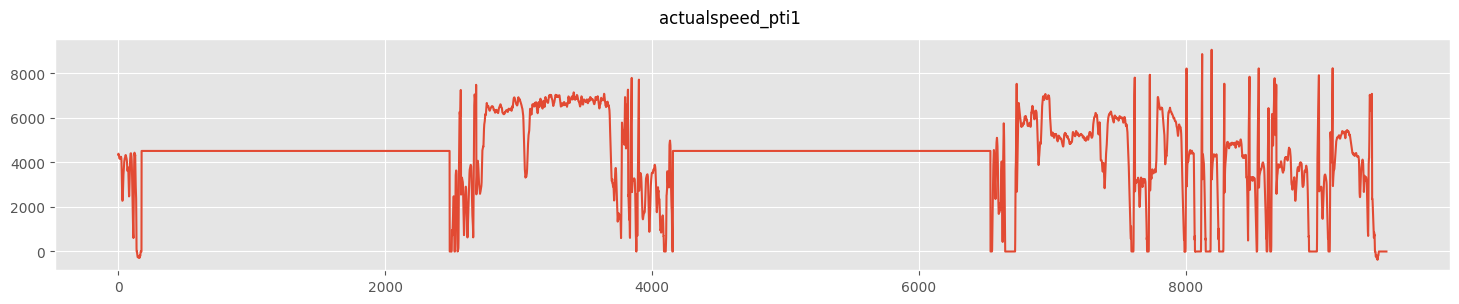

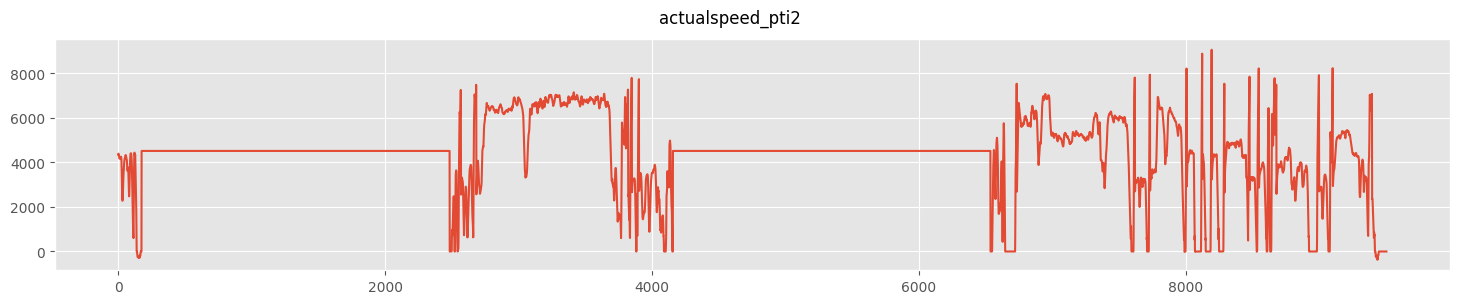

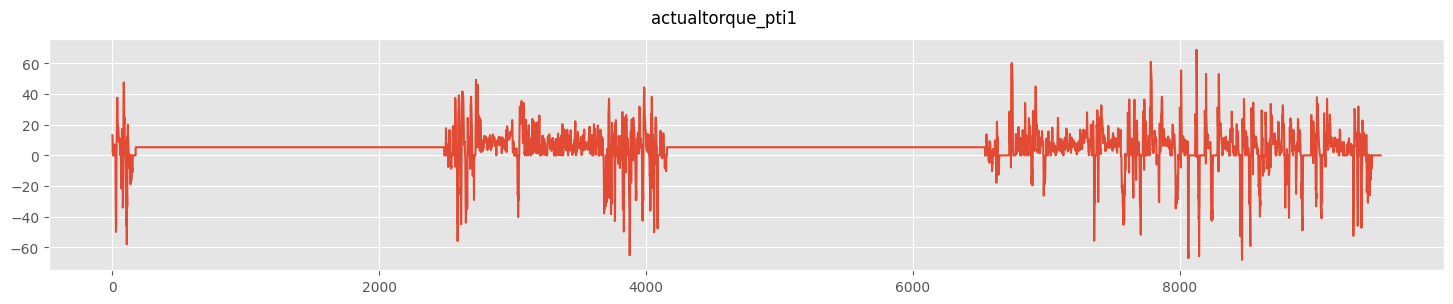

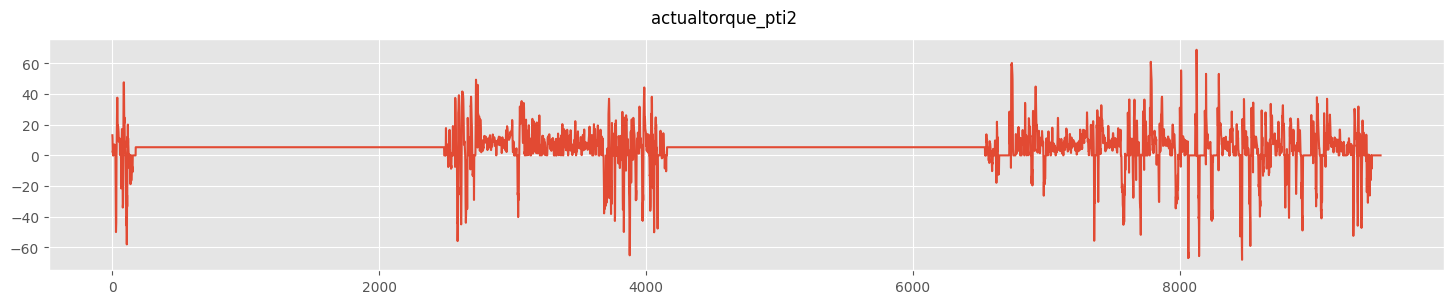

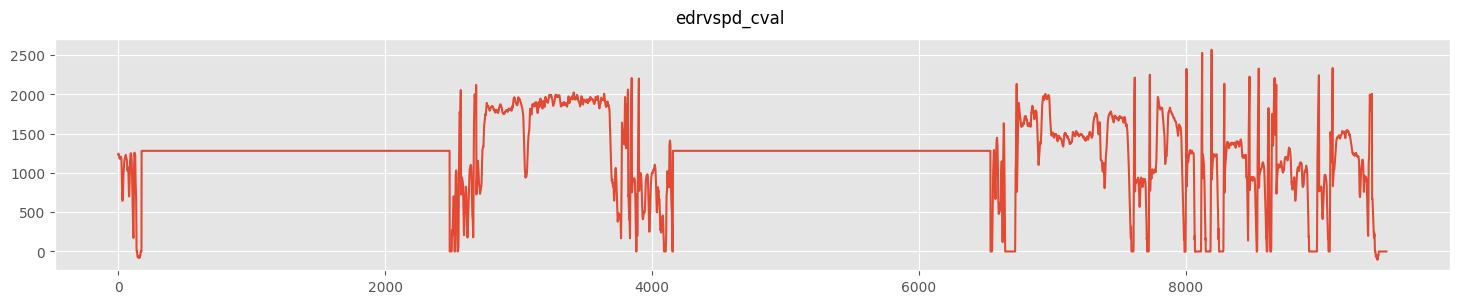

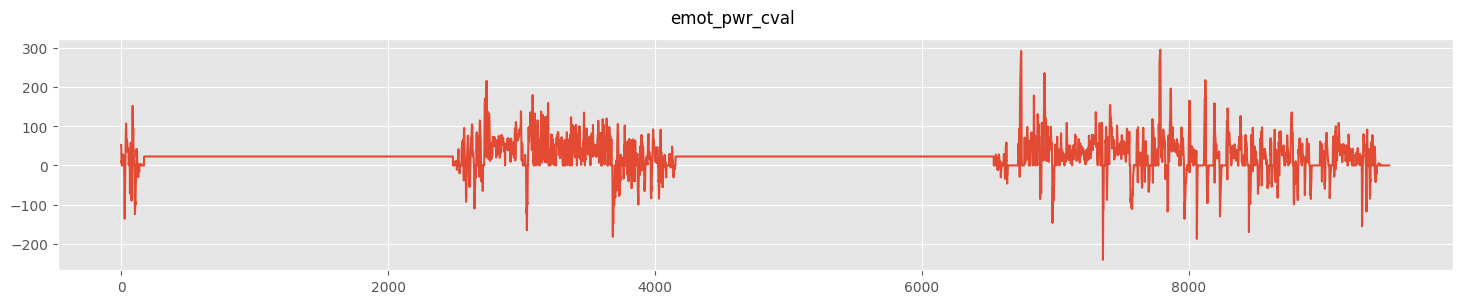

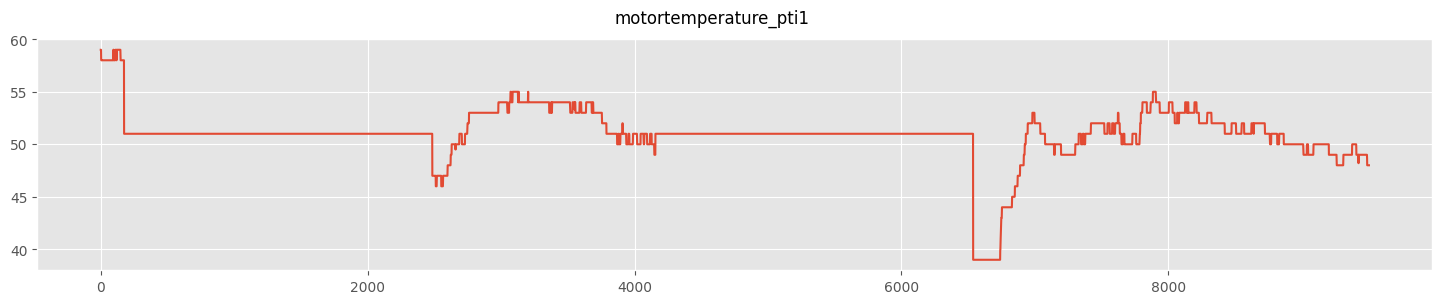

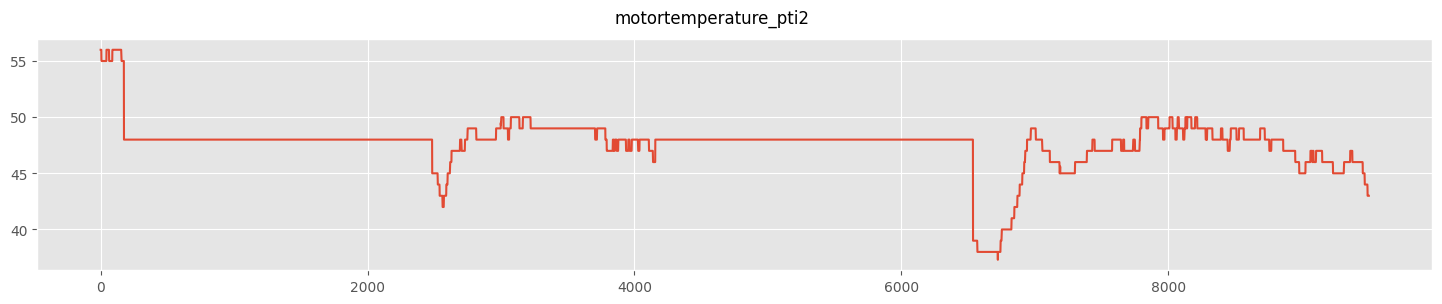

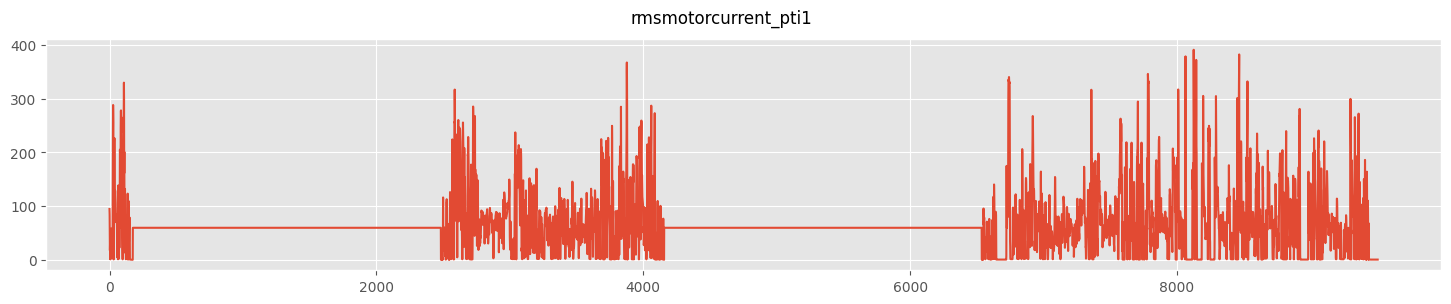

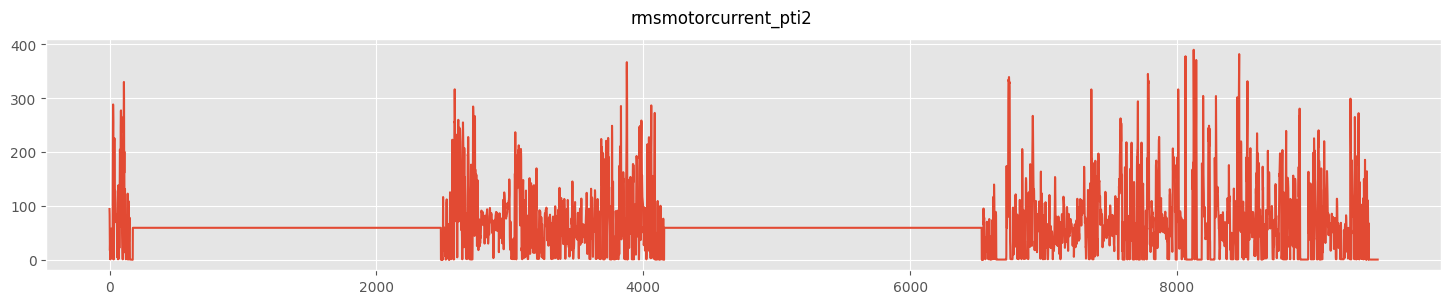

drivetrain_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


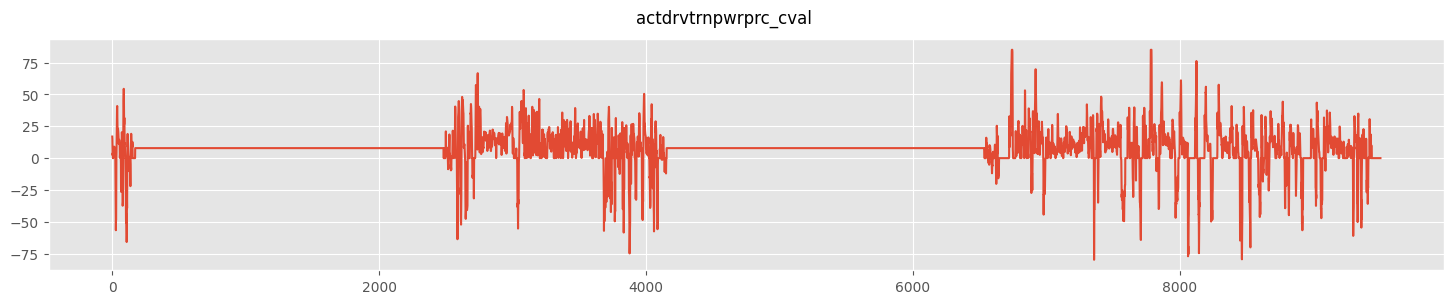

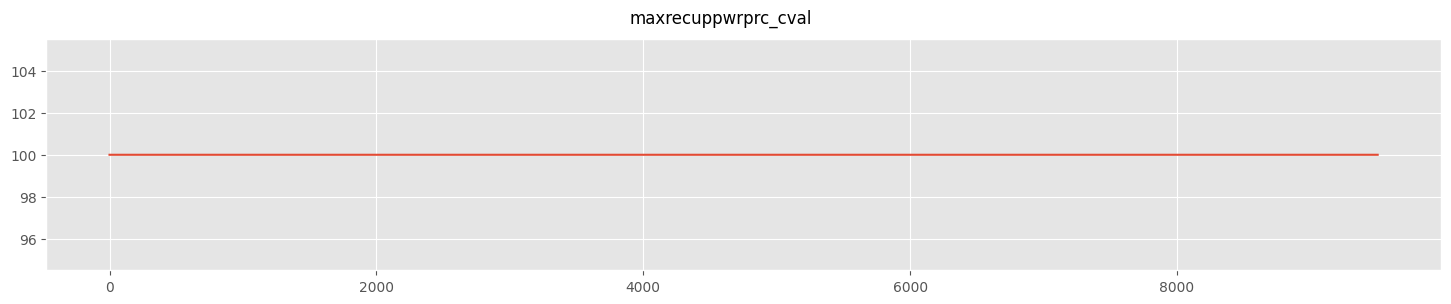

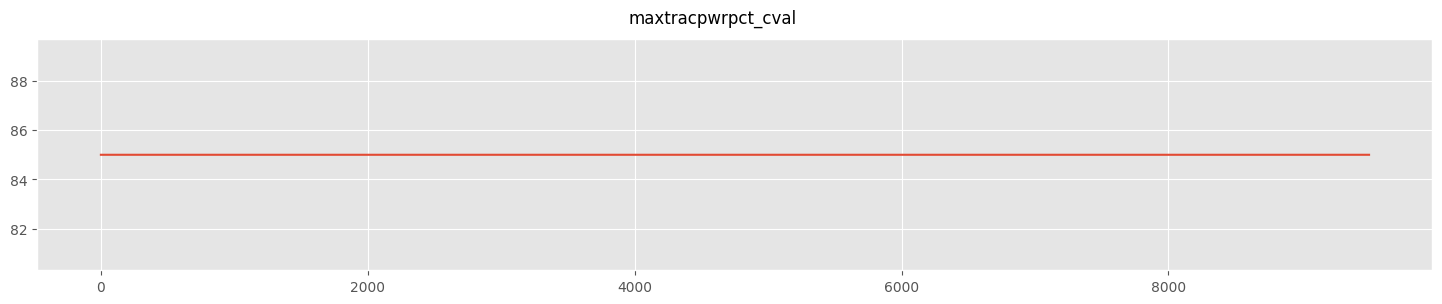

transmission_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


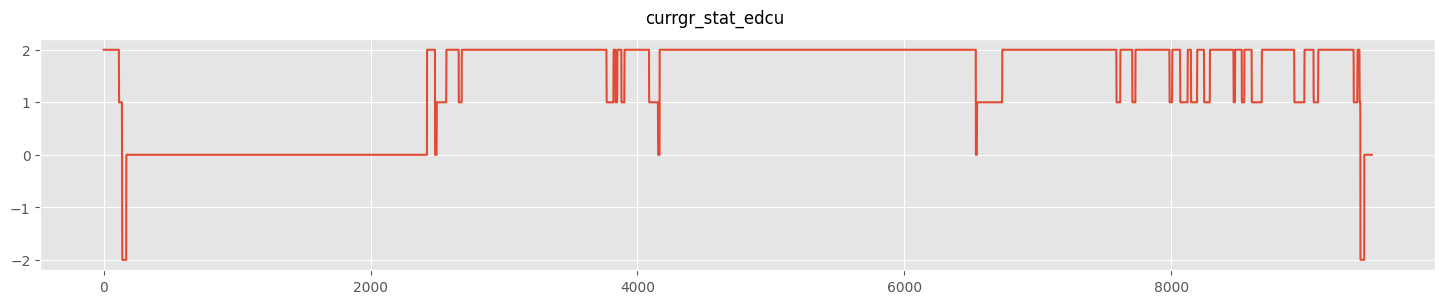

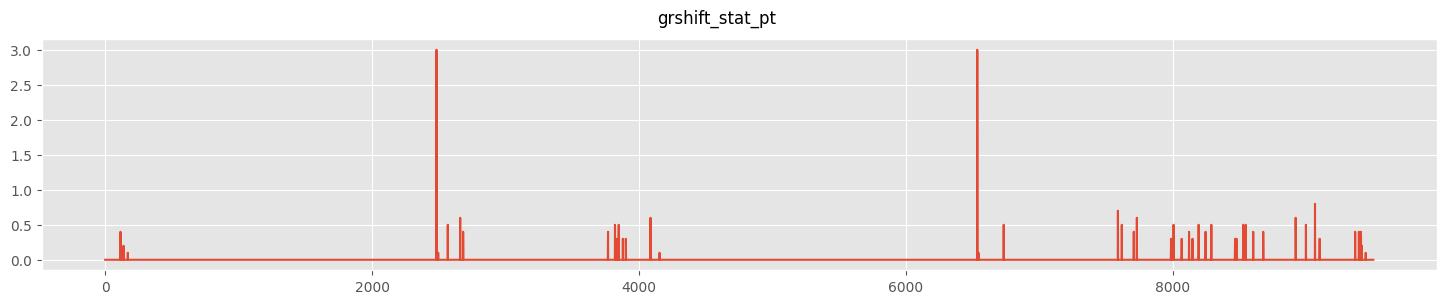

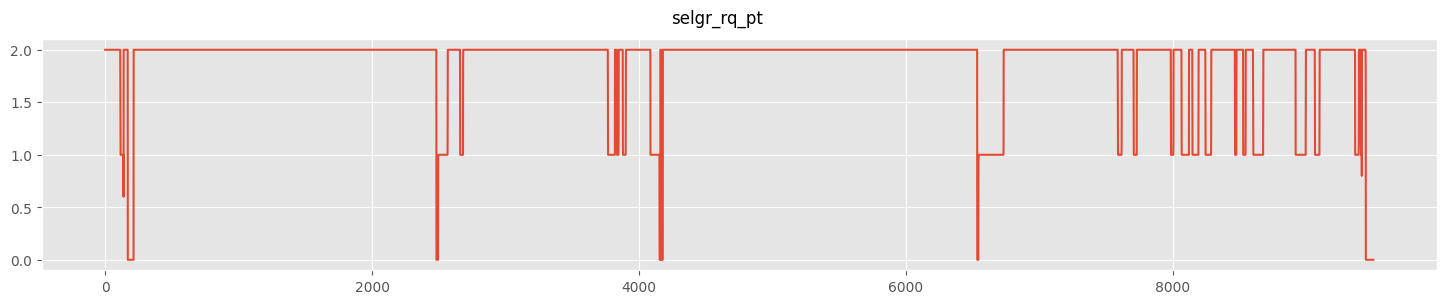

bat_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


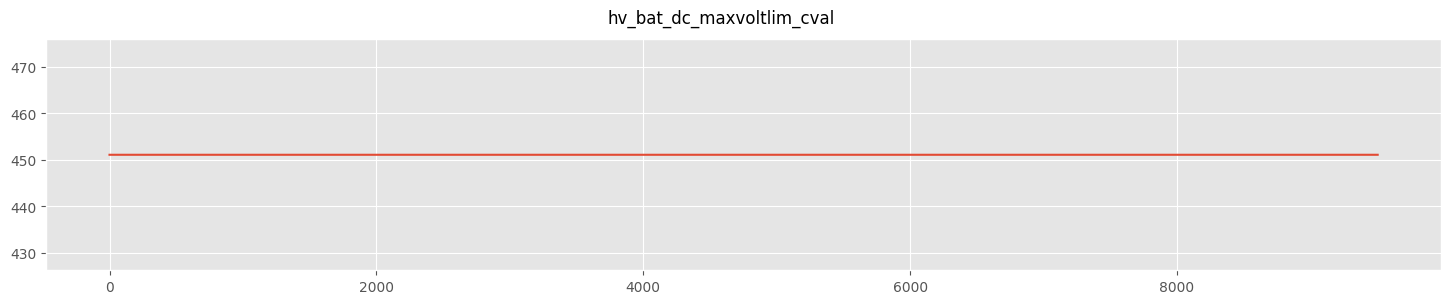

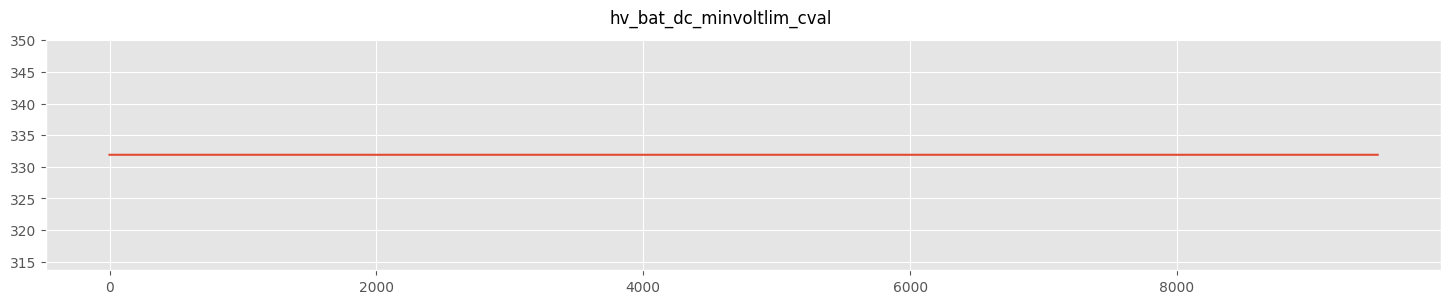

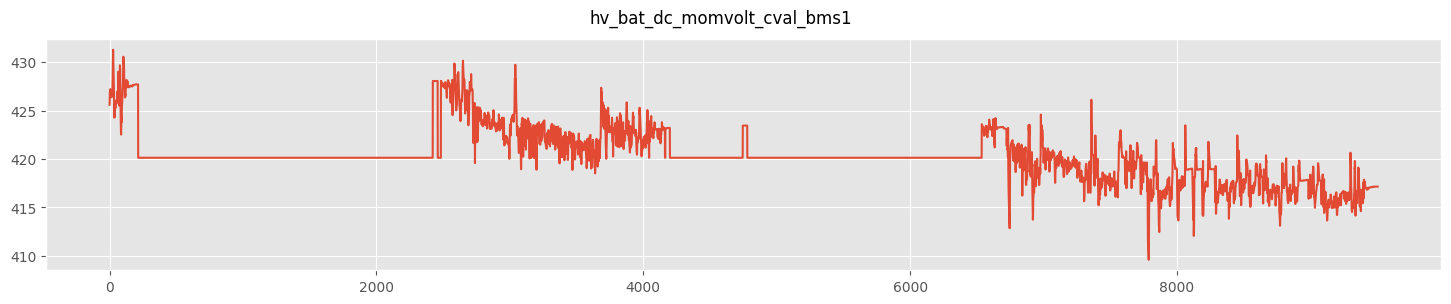

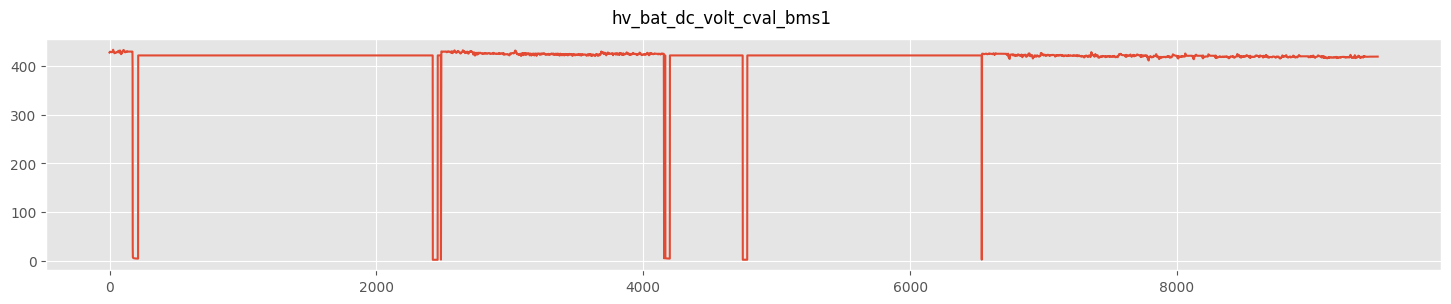

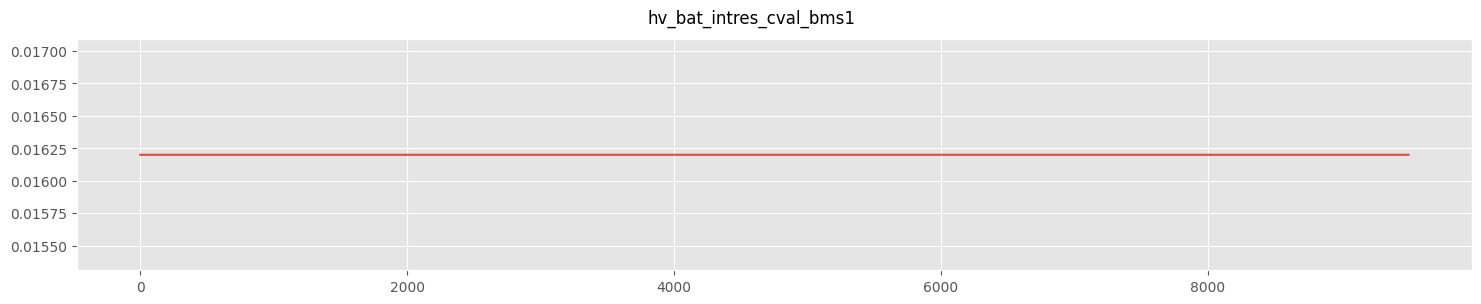

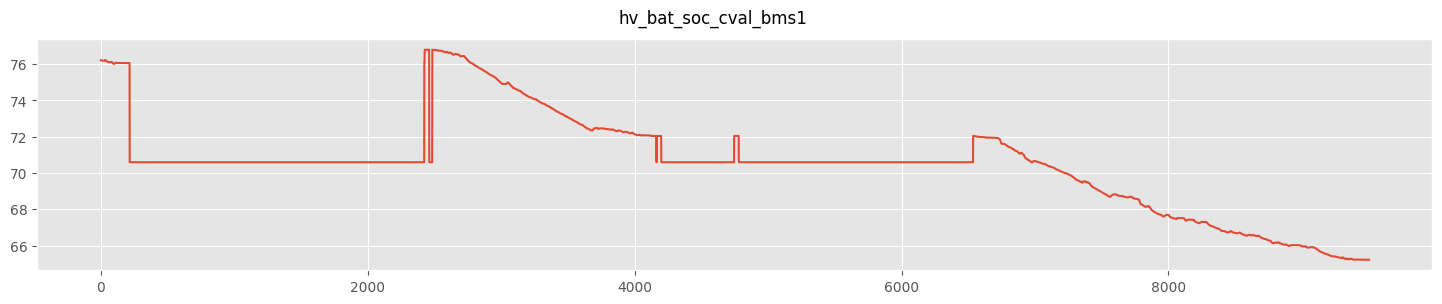

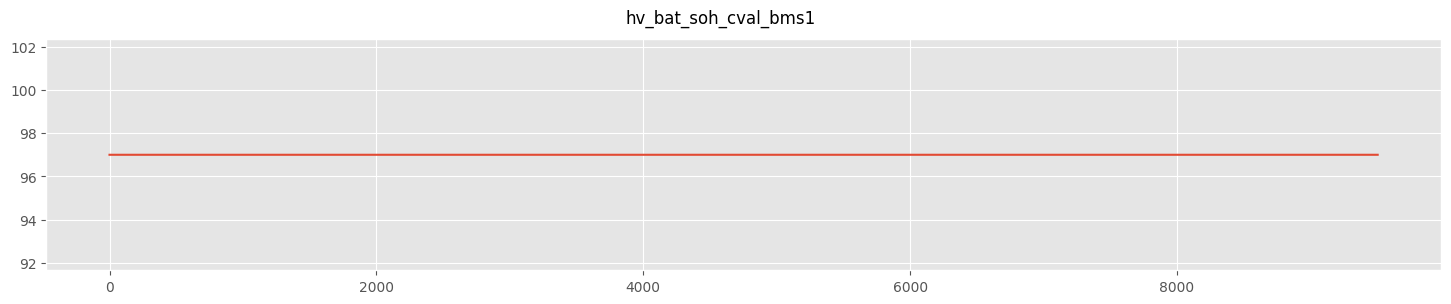

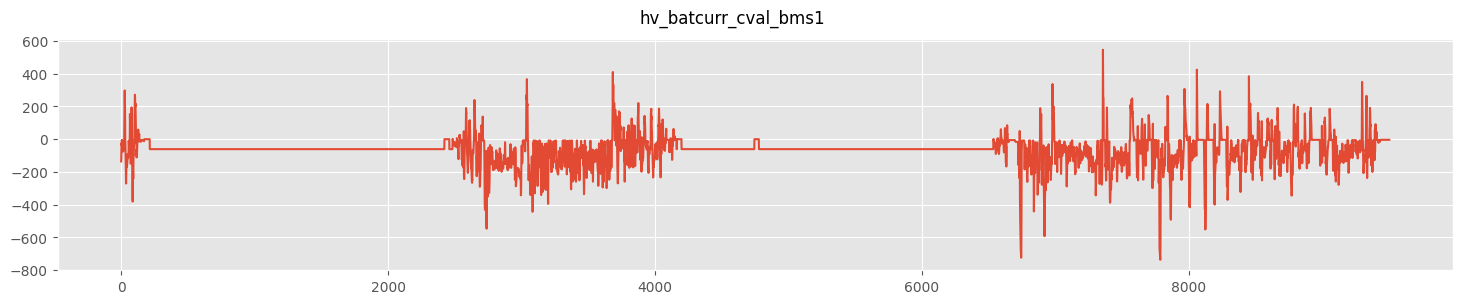

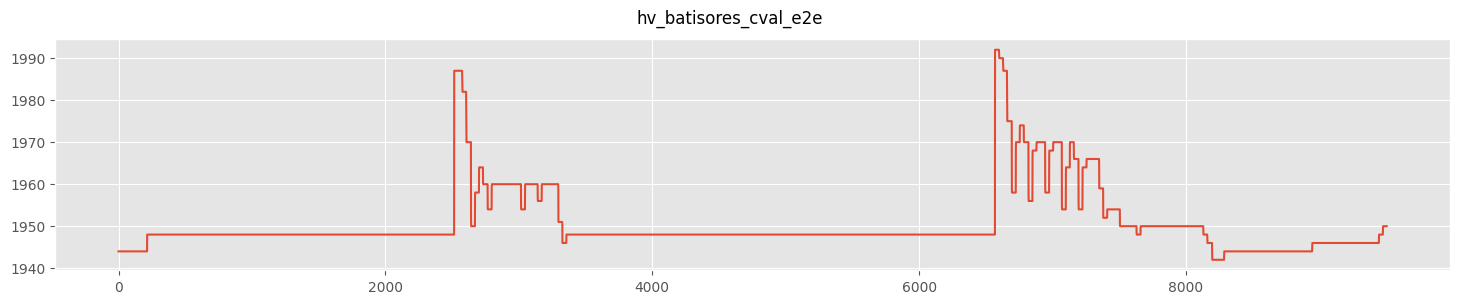

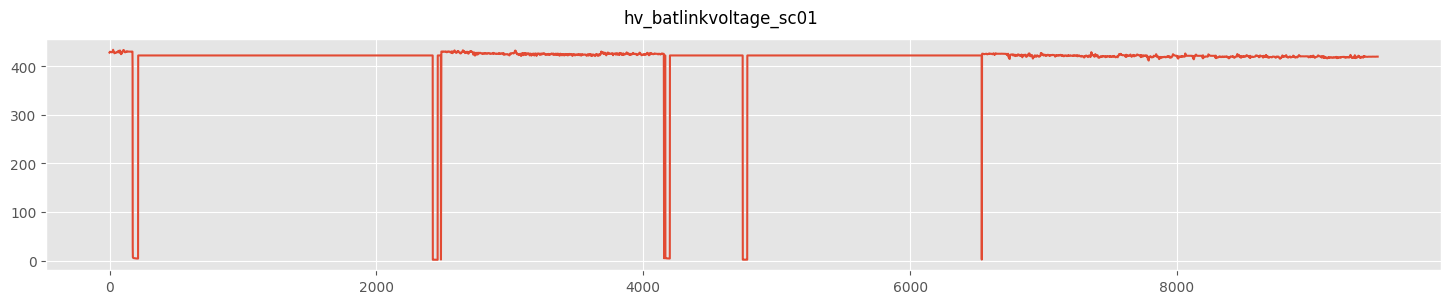

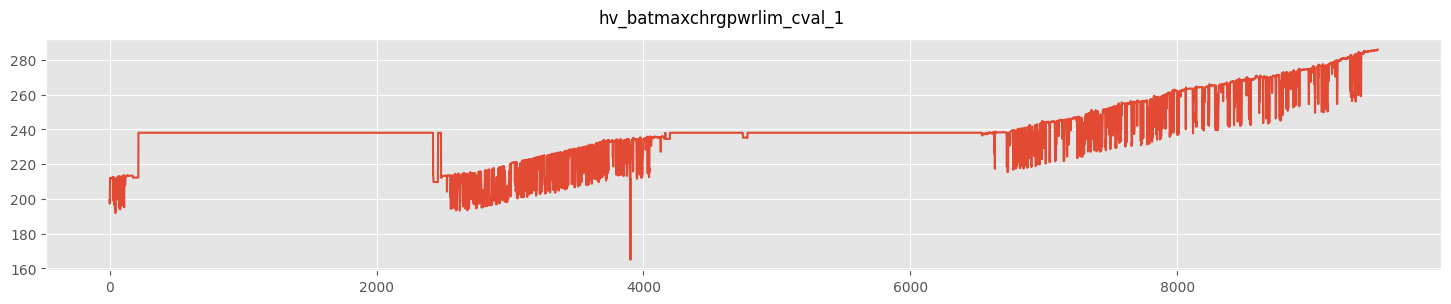

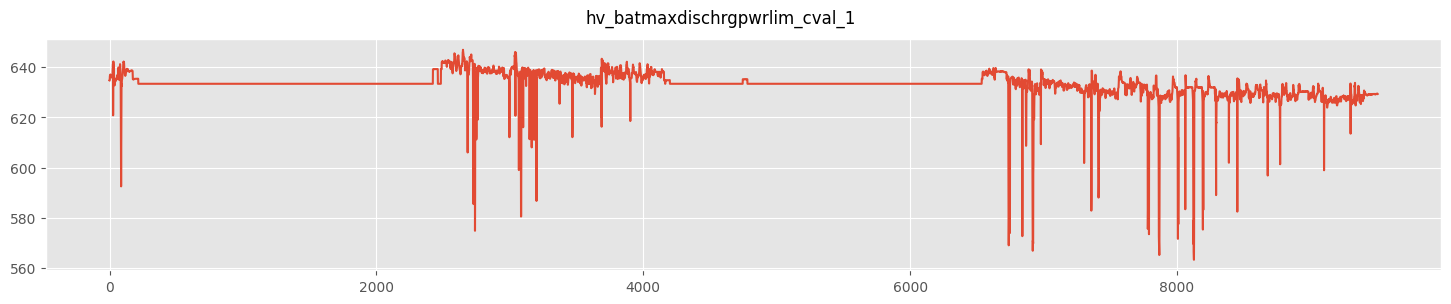

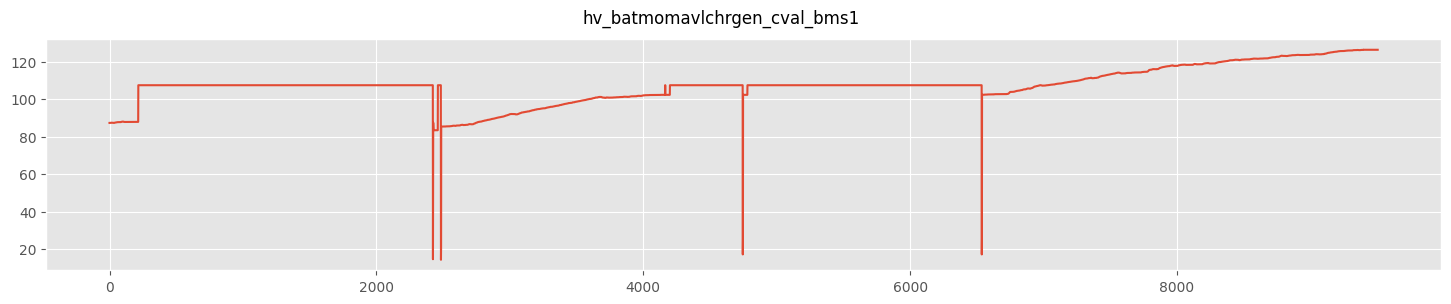

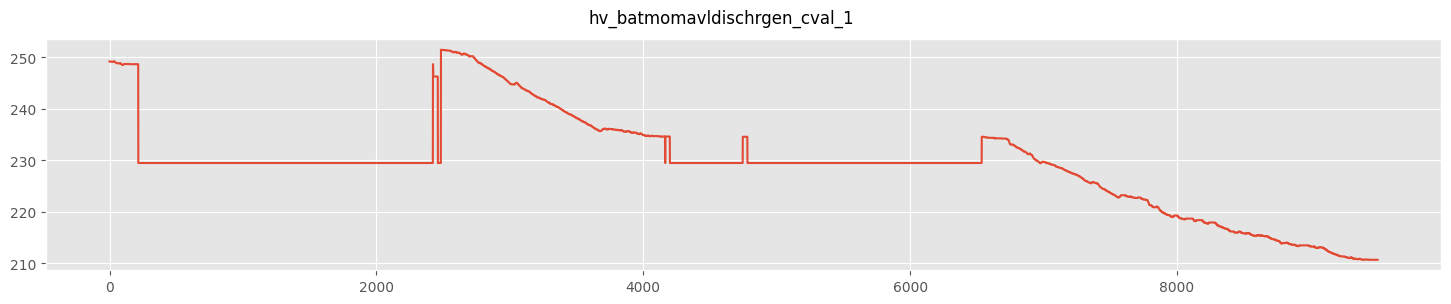

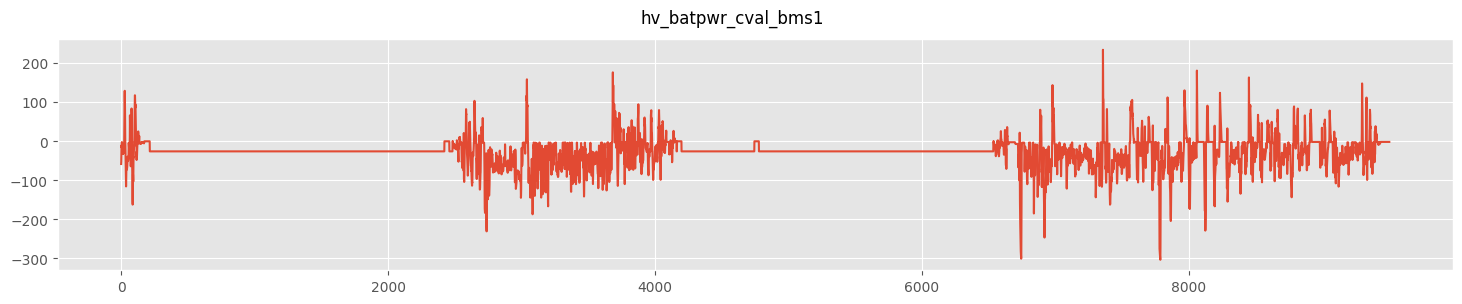

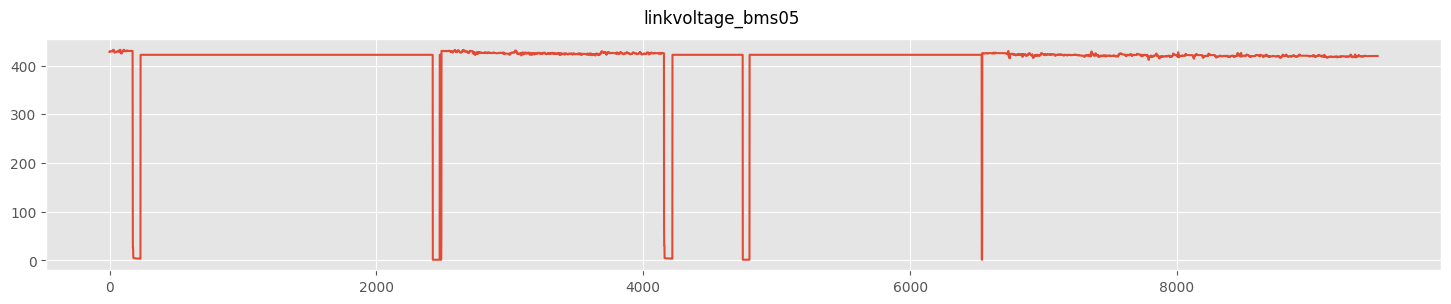

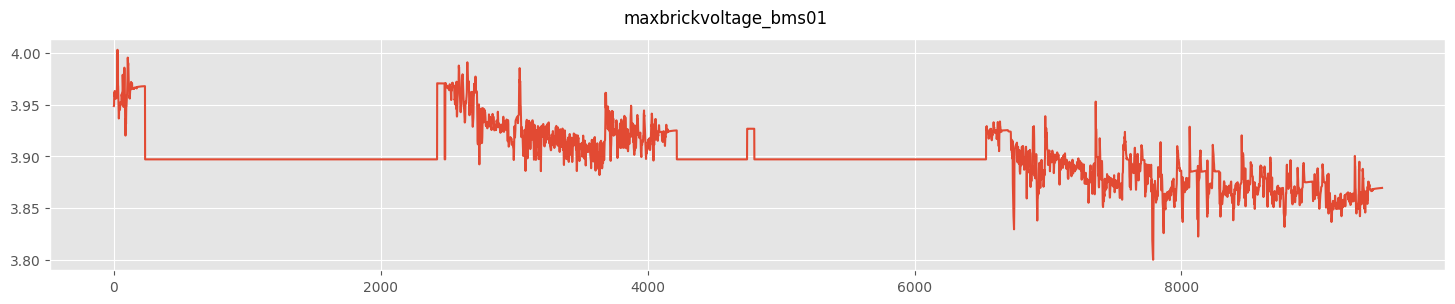

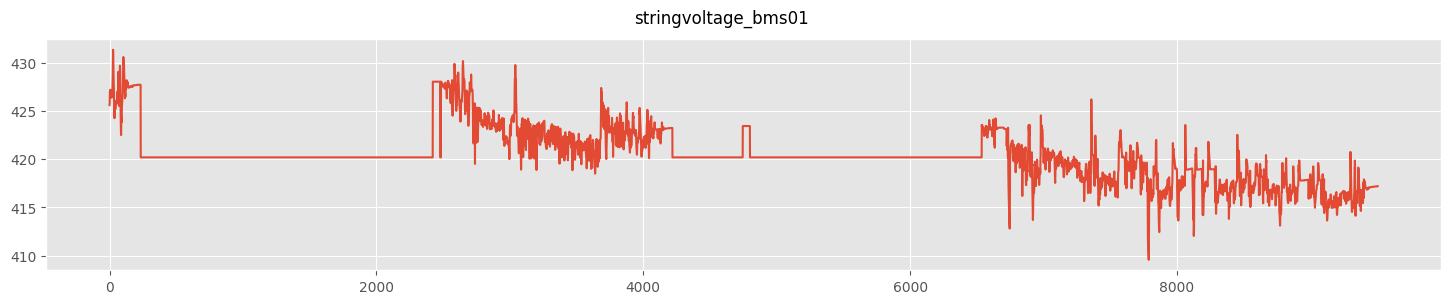

bat_cell_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


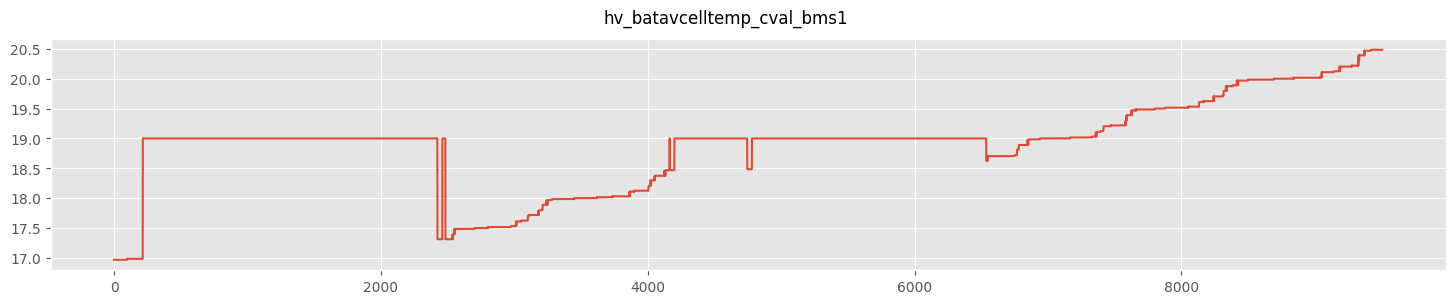

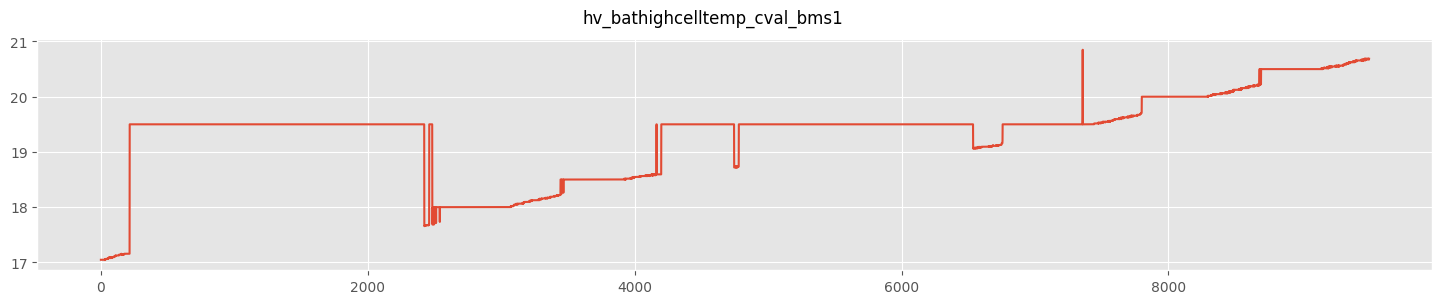

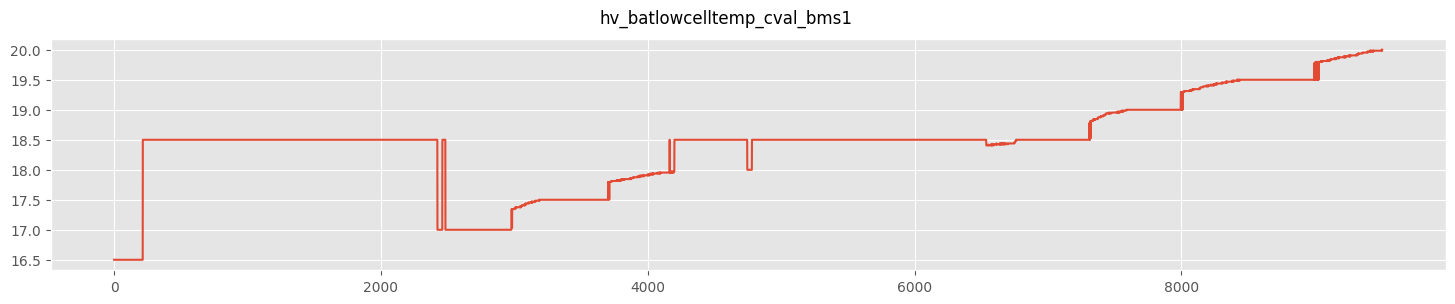

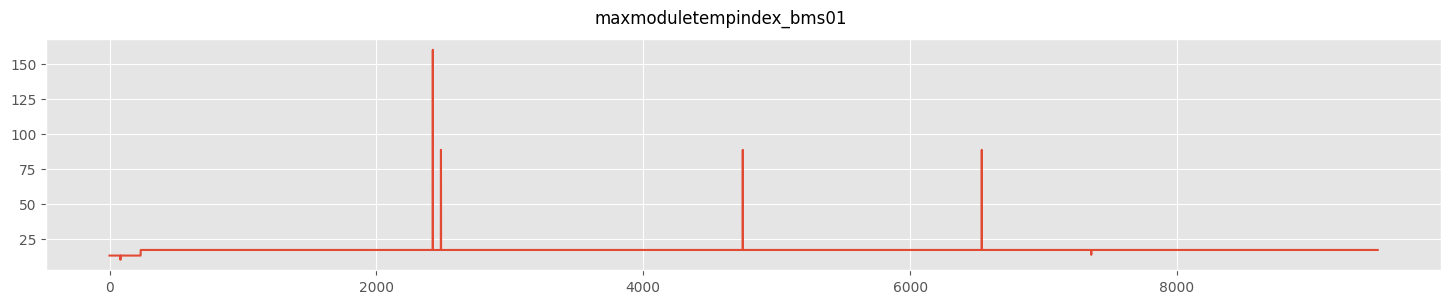

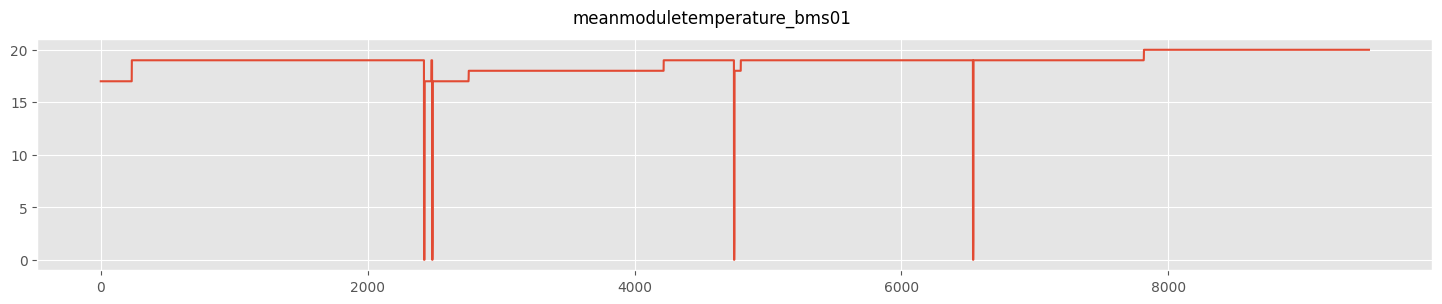

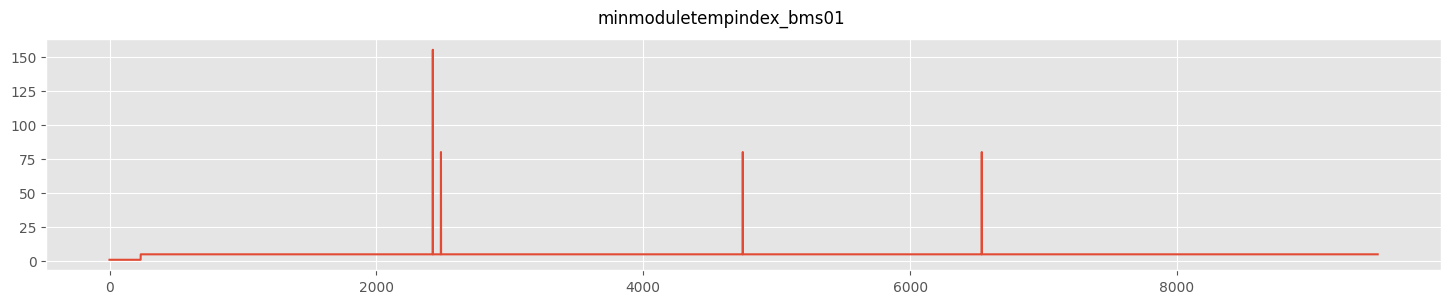

electronics_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


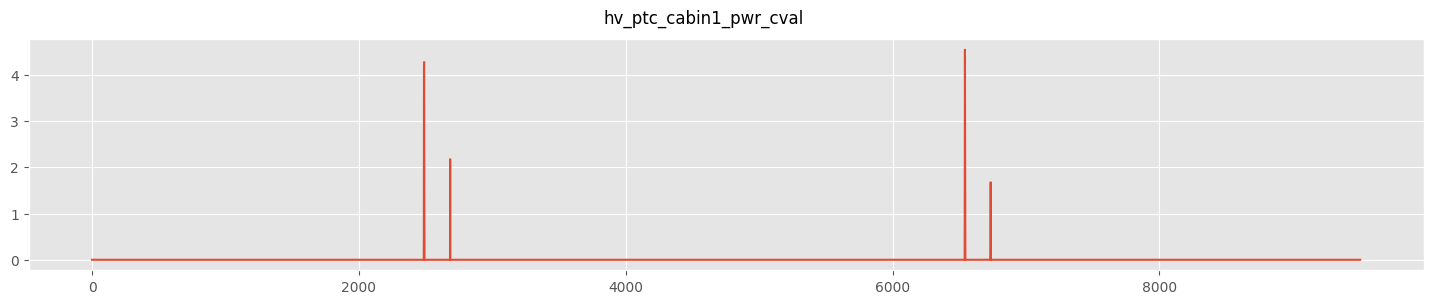

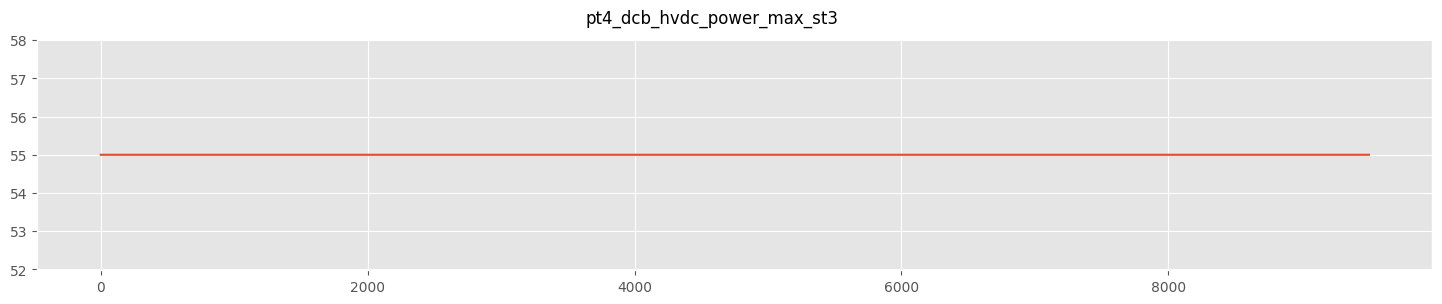

inverter_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


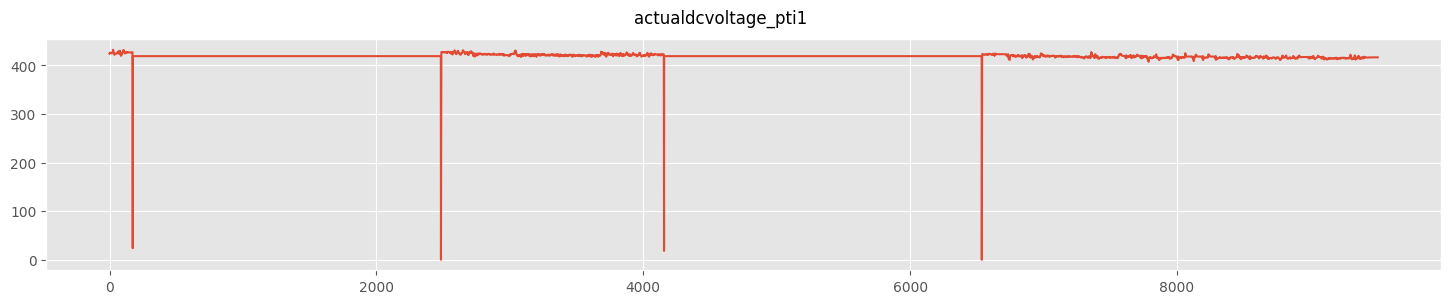

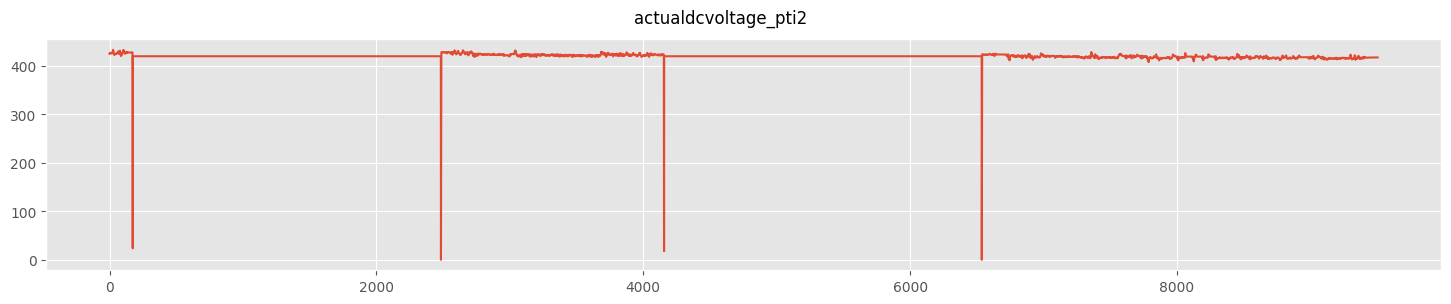

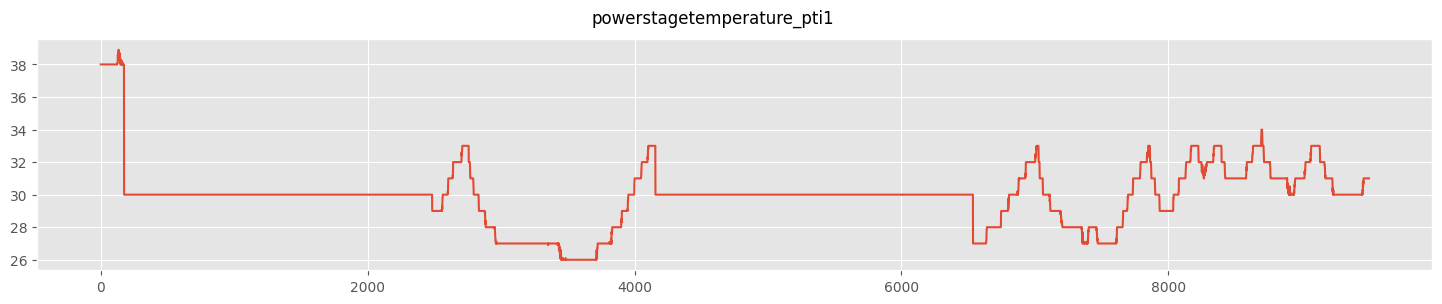

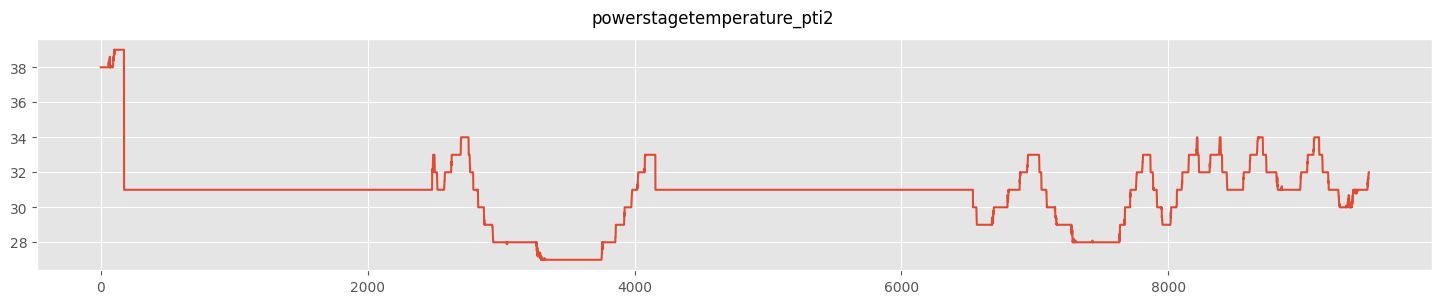

converter_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


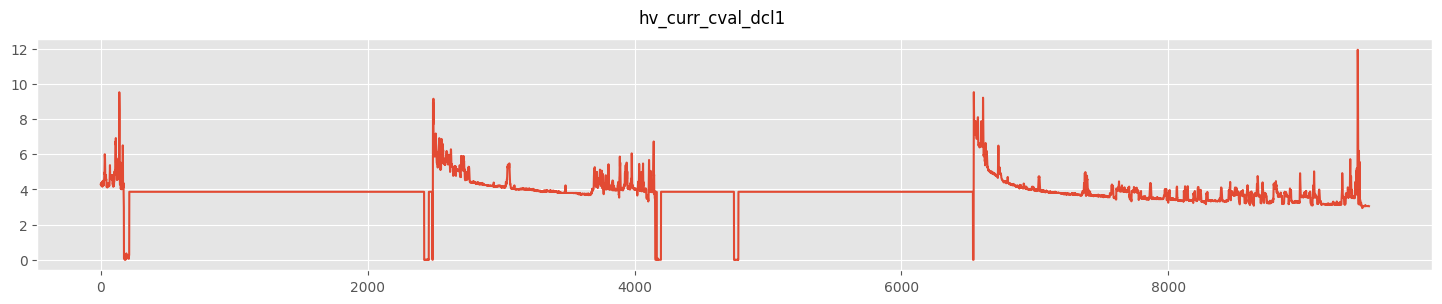

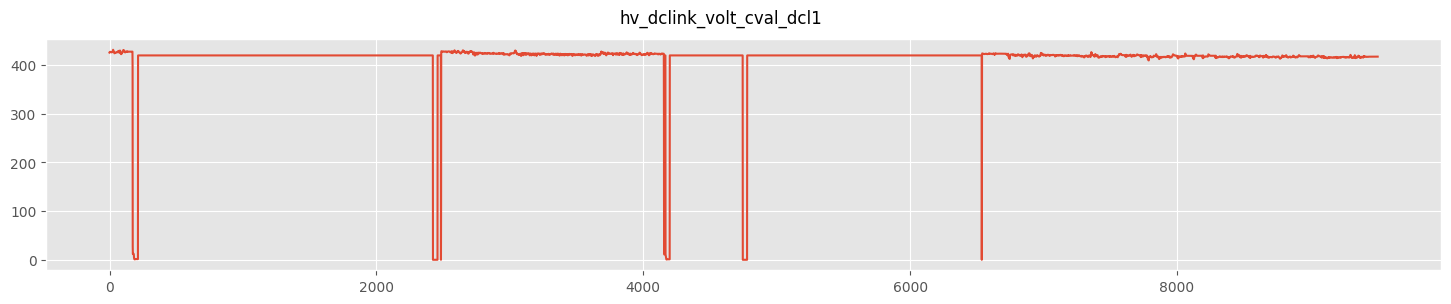

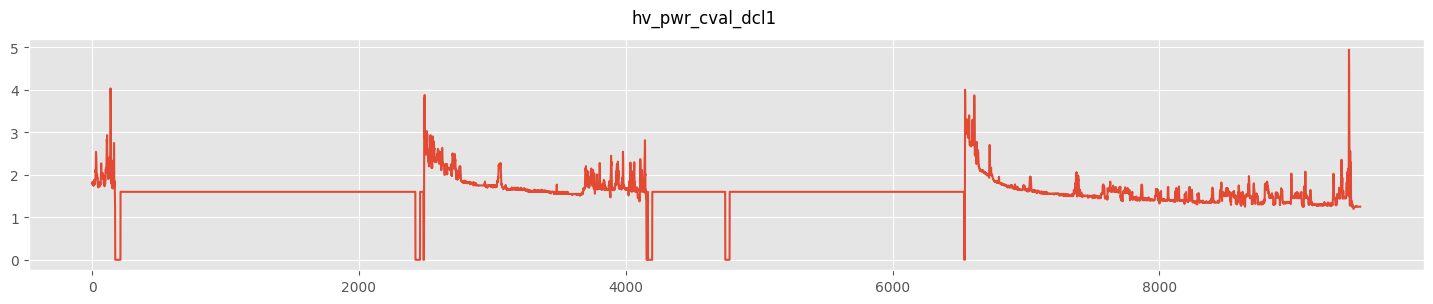

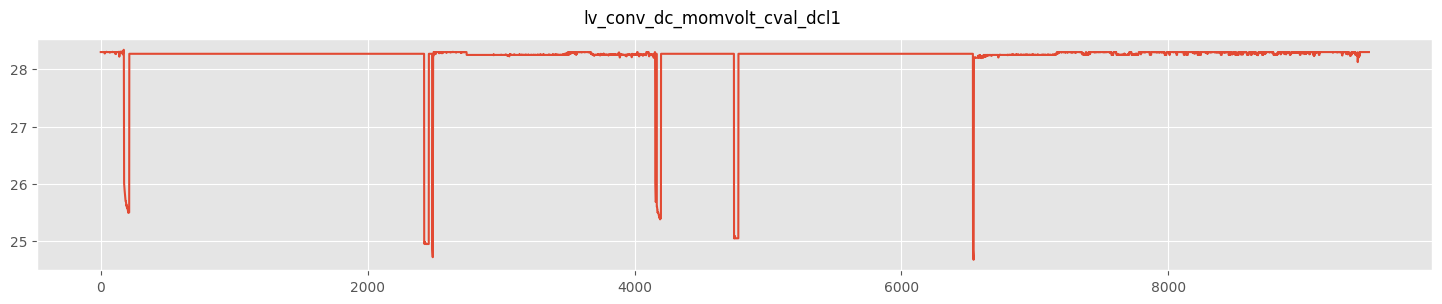

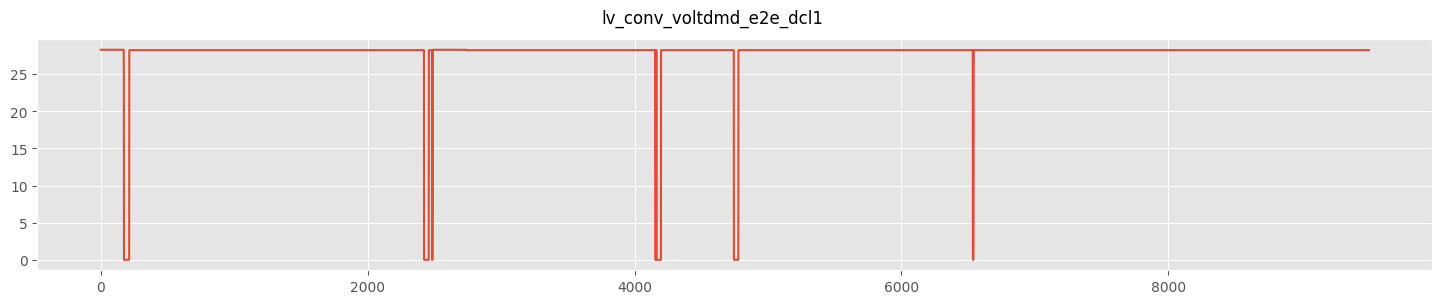

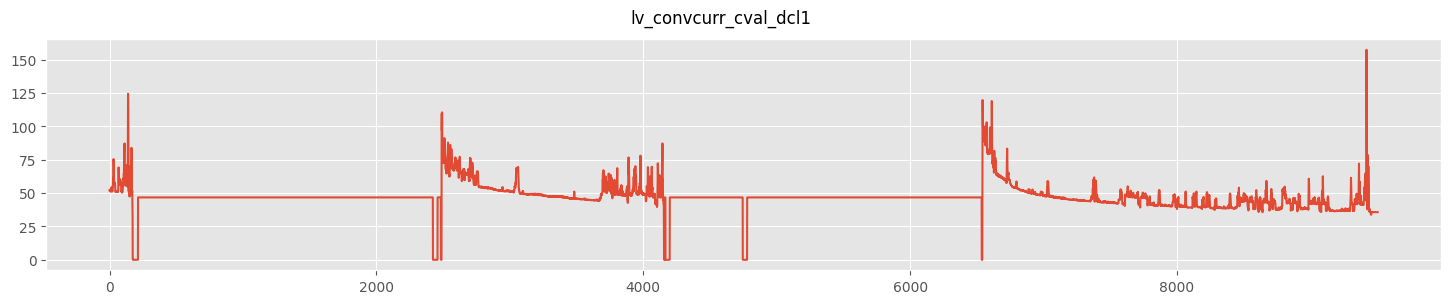

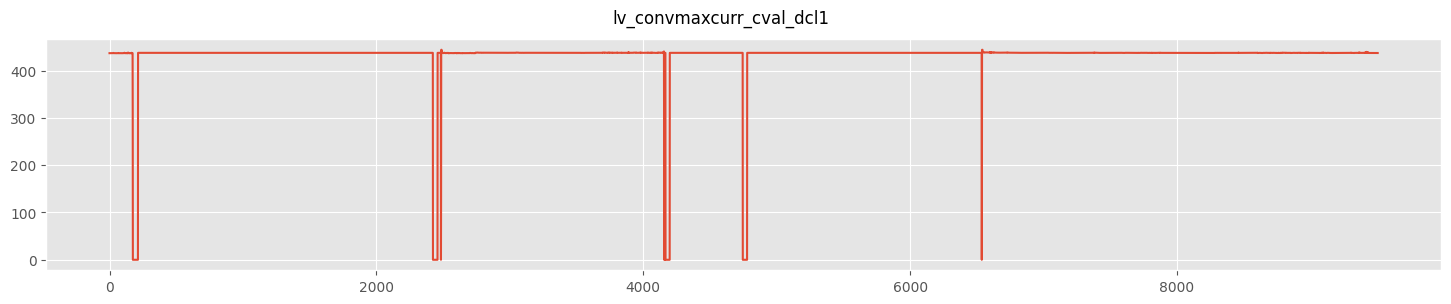

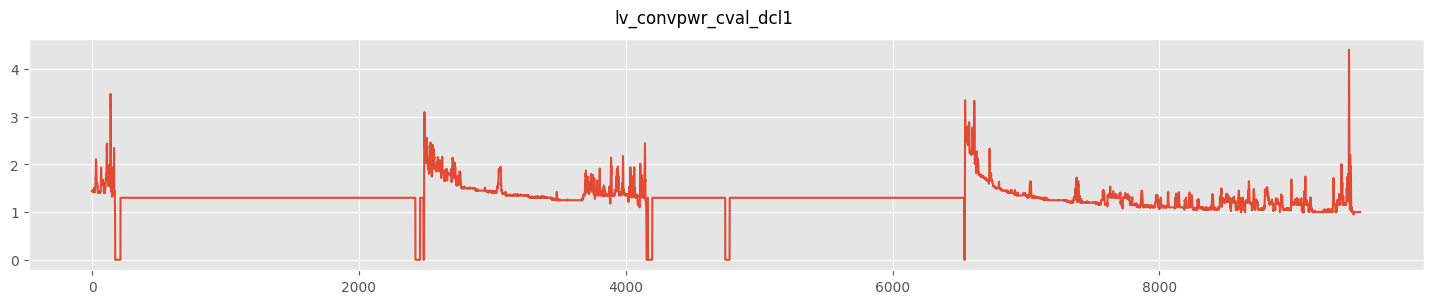

brc_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


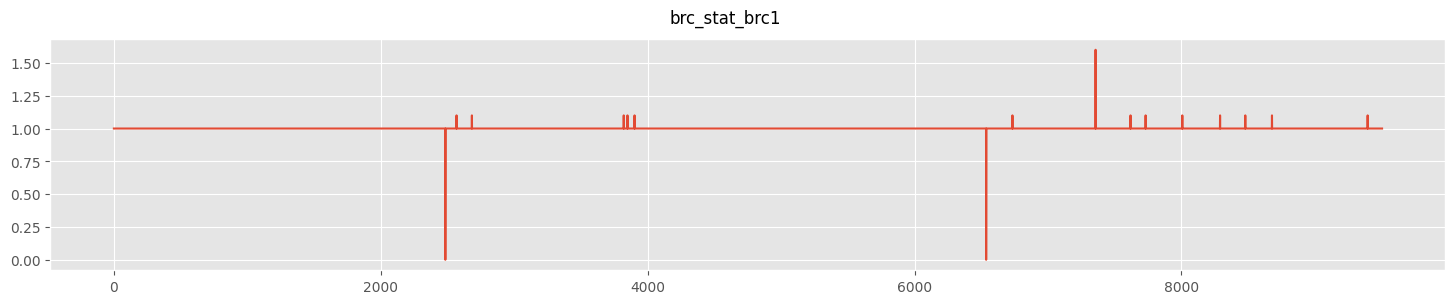

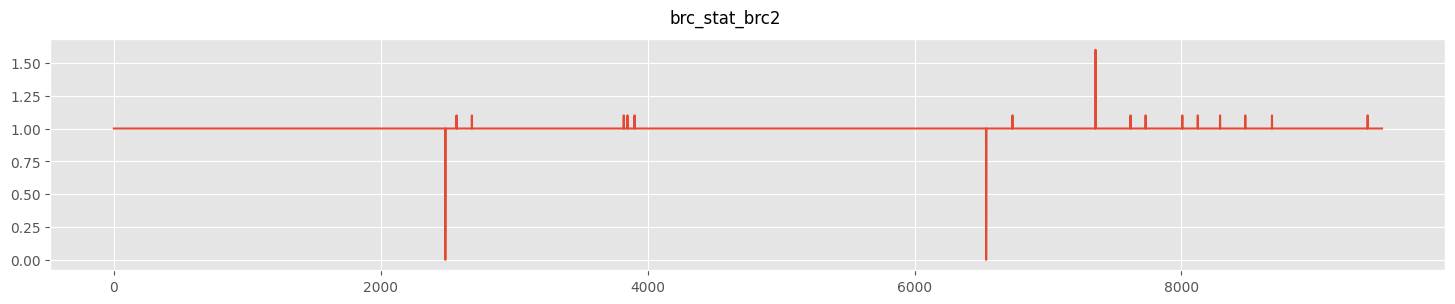

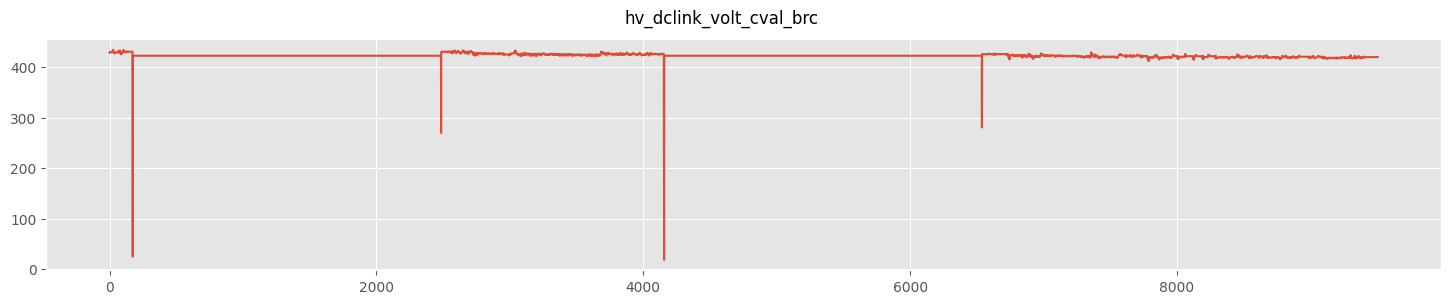

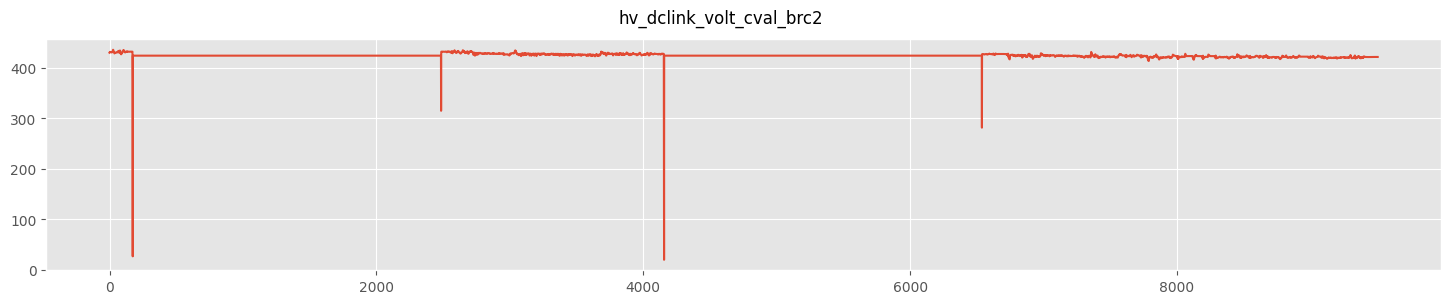

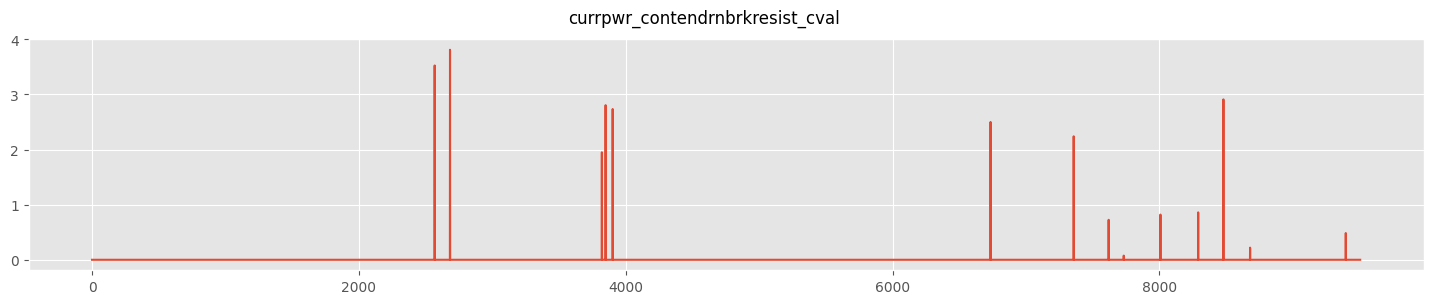

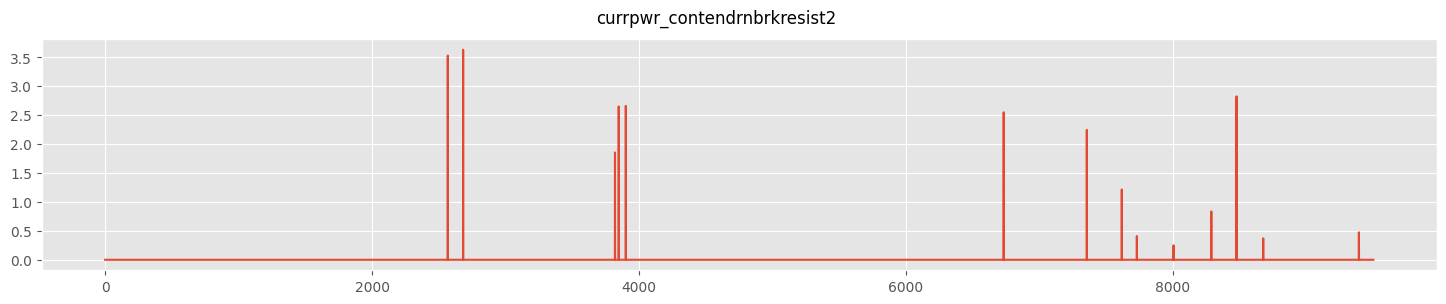

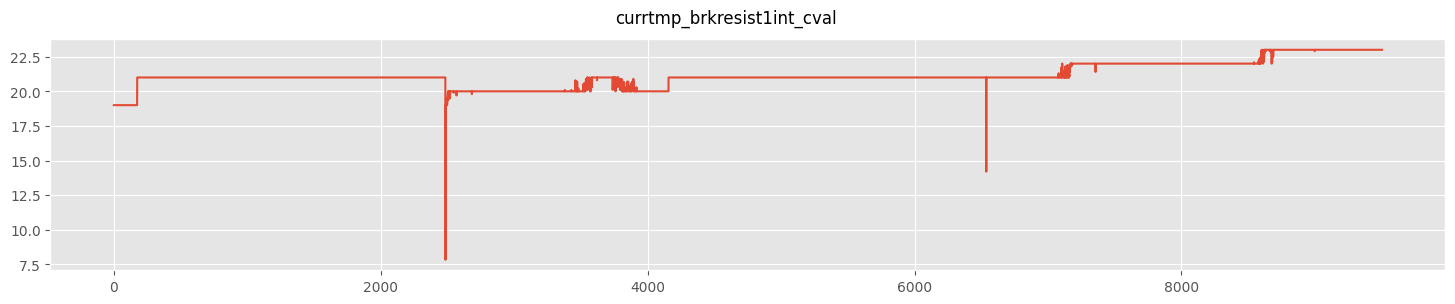

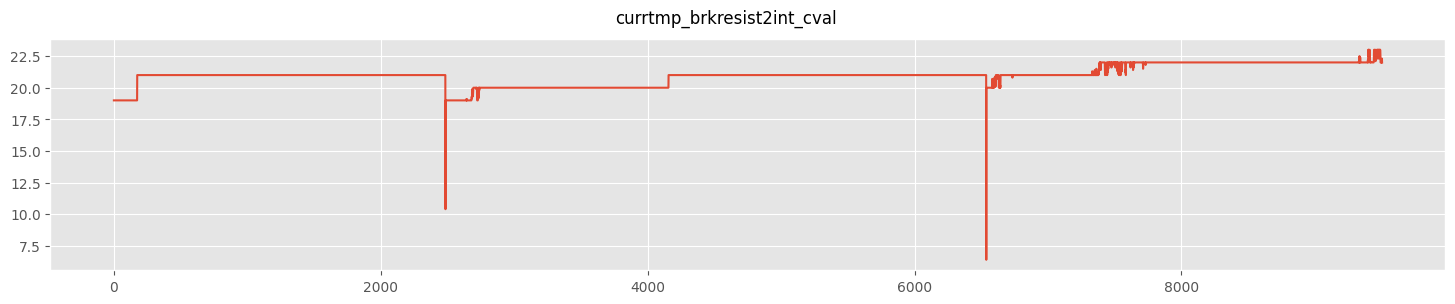

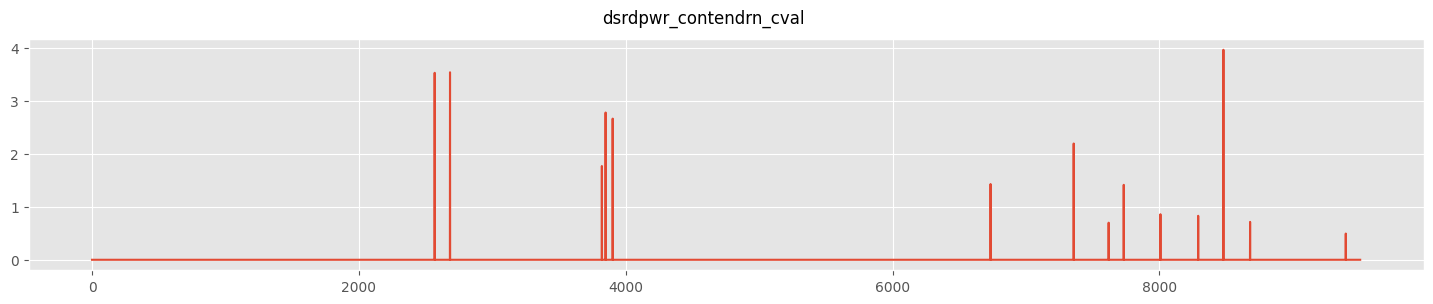

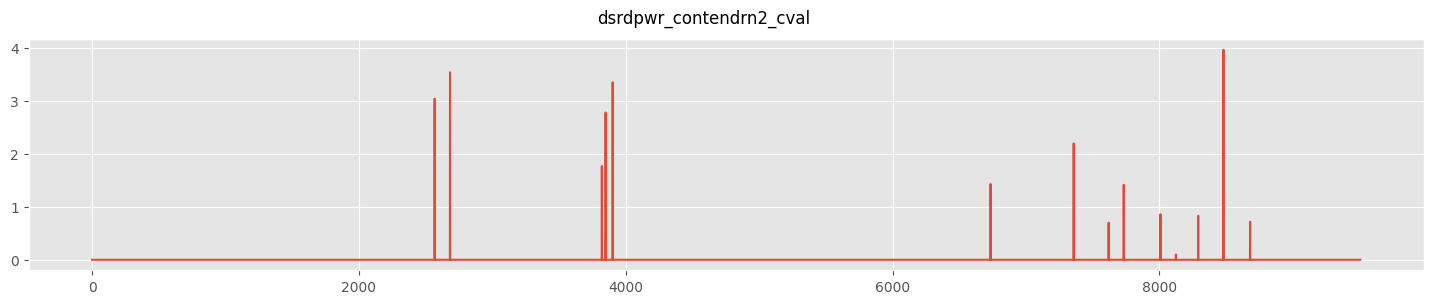

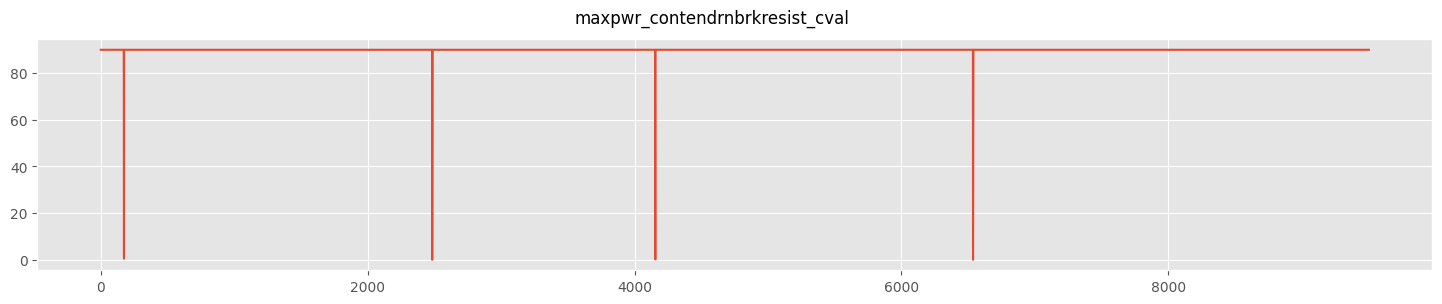

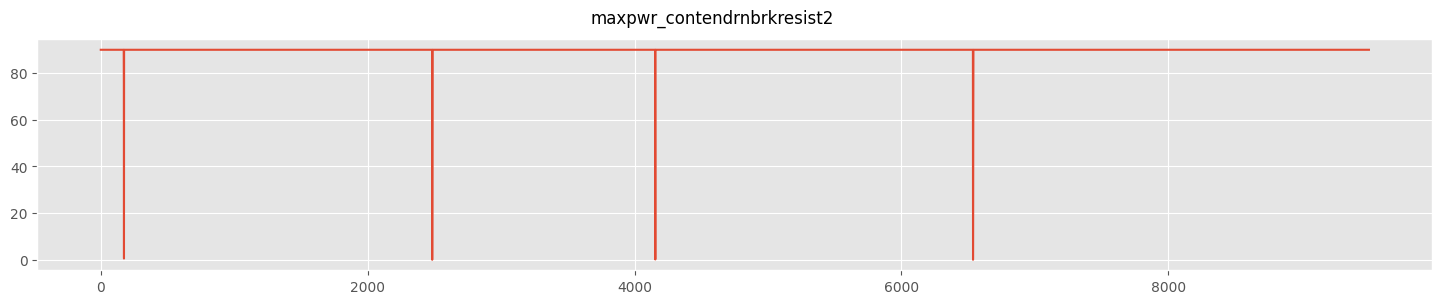

charge_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


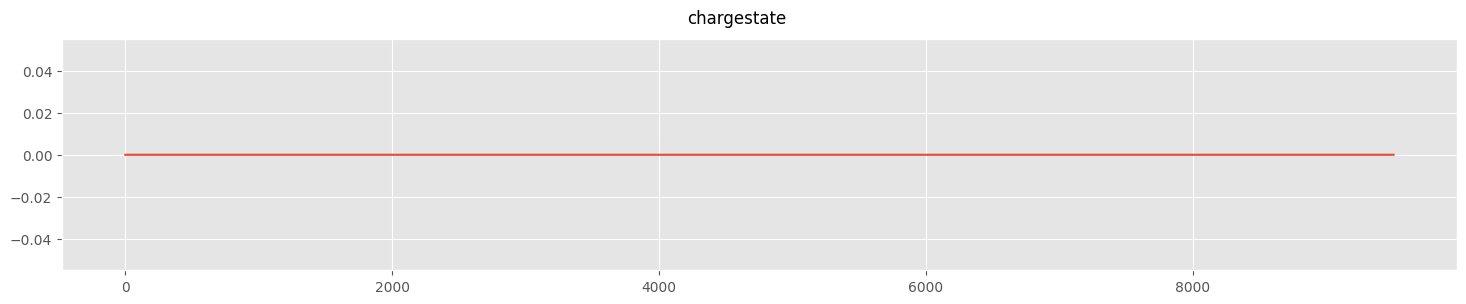

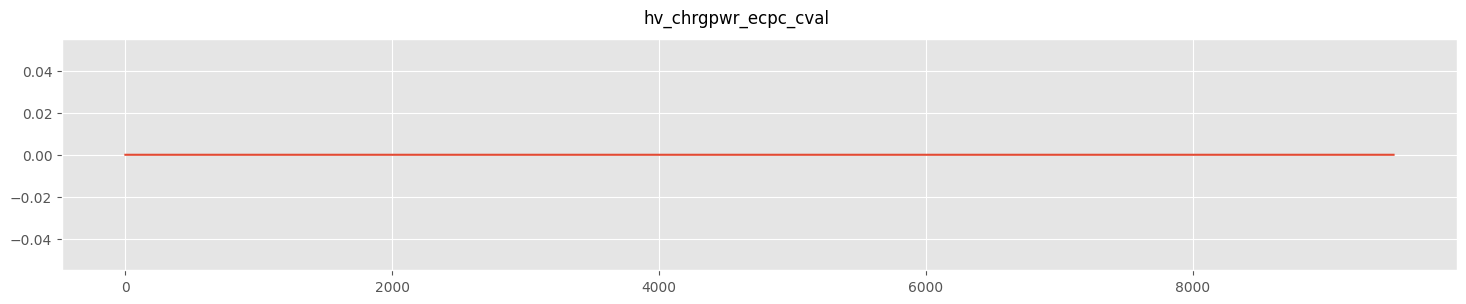

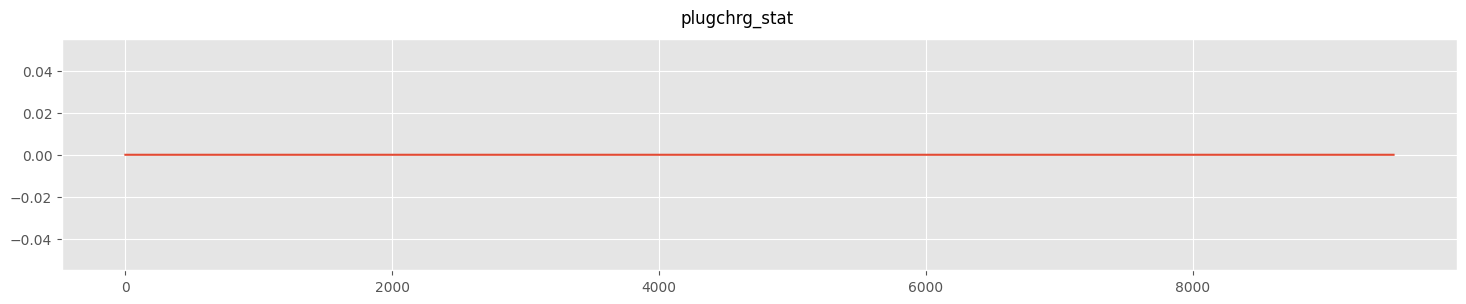

control_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


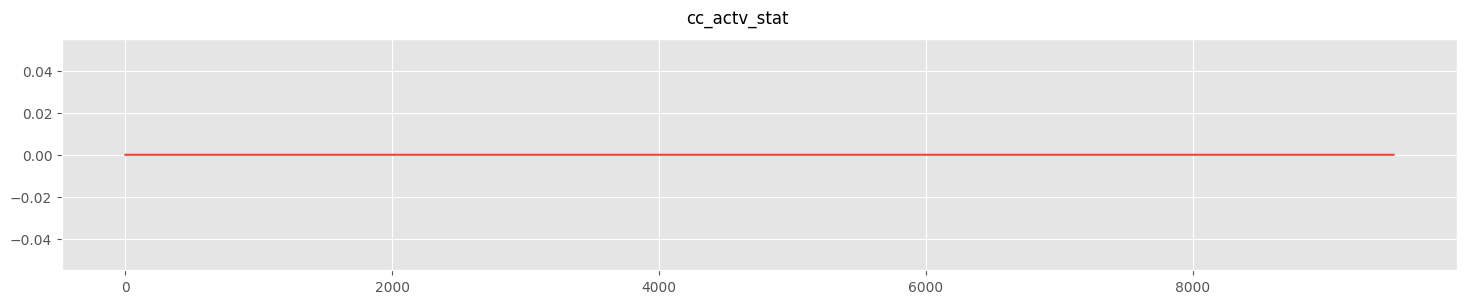

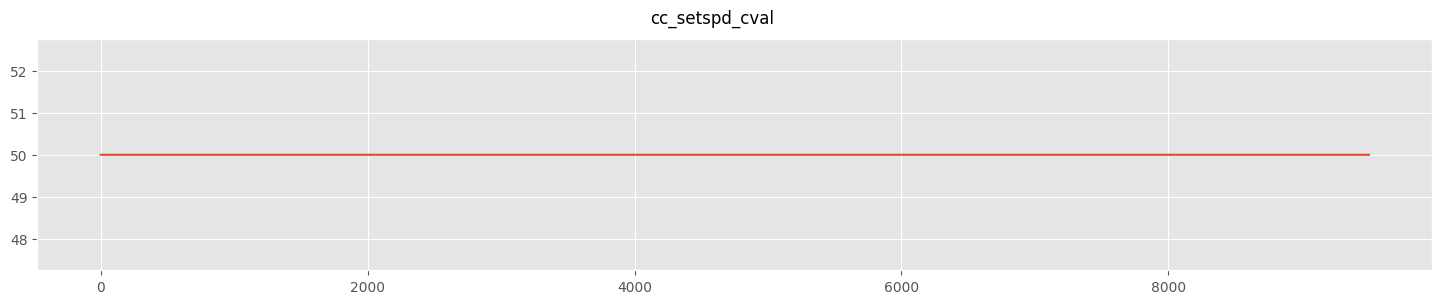

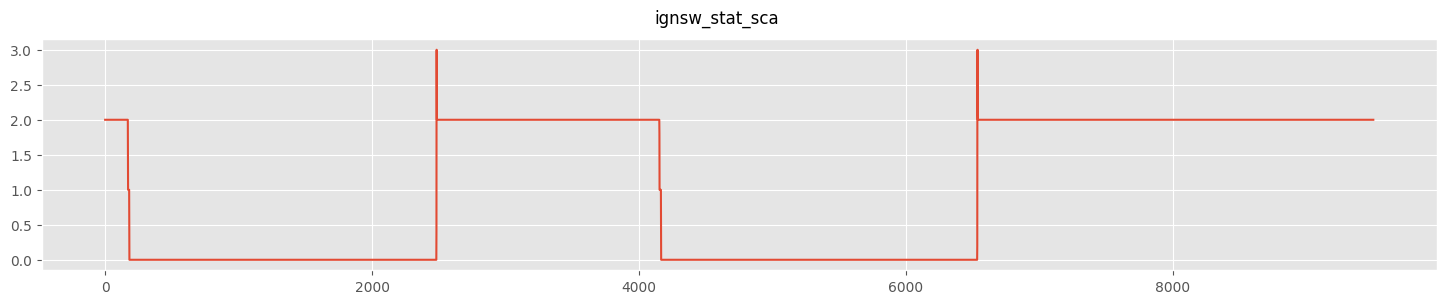

aux_pto_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


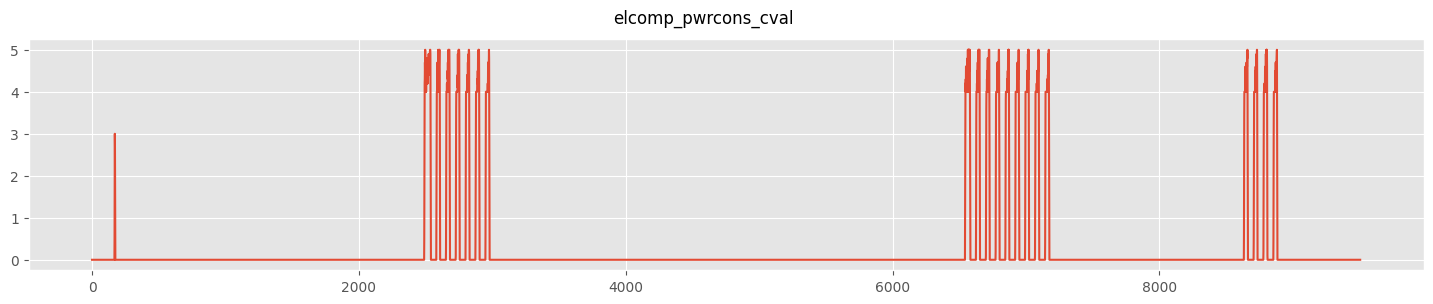

temp_sig :
------------------------------------------------------------------------------------------------------------------------------------------------------


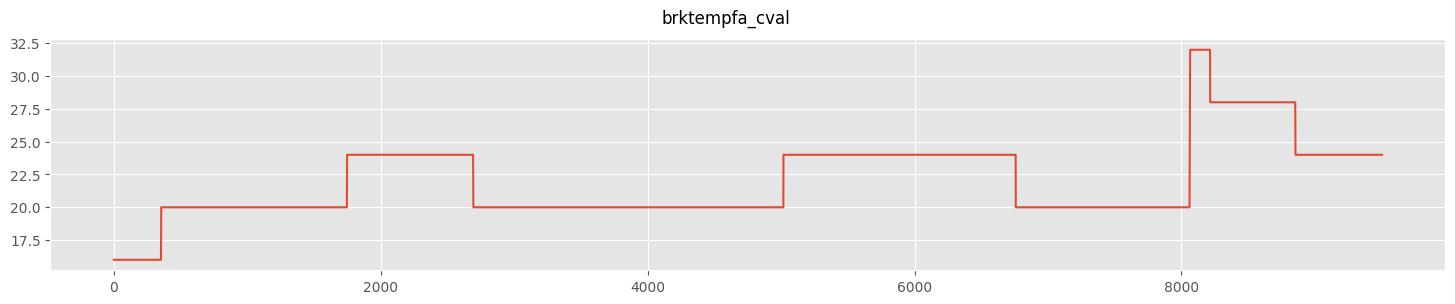

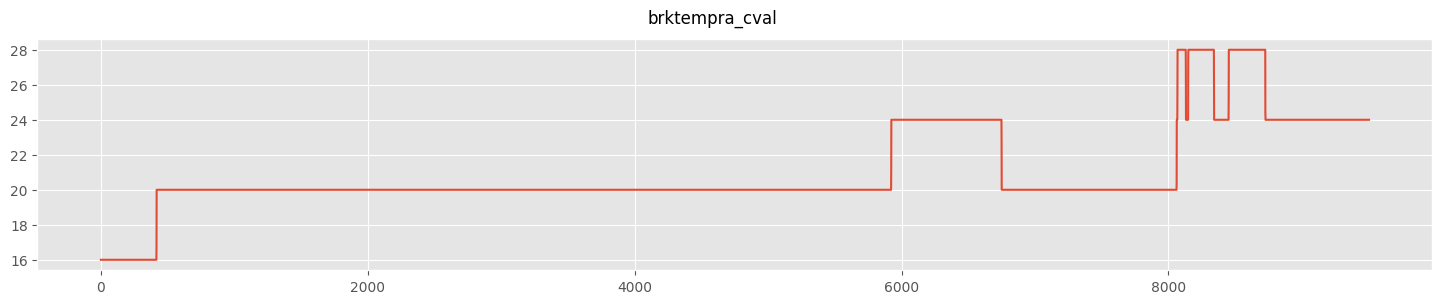

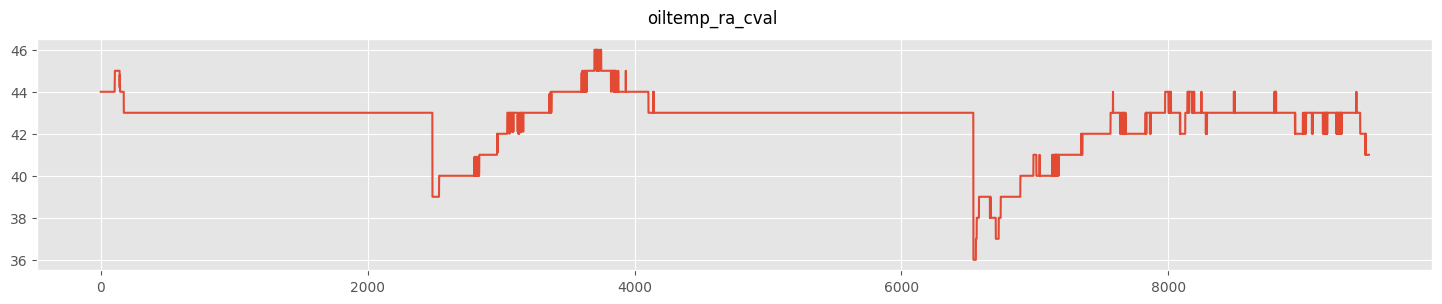

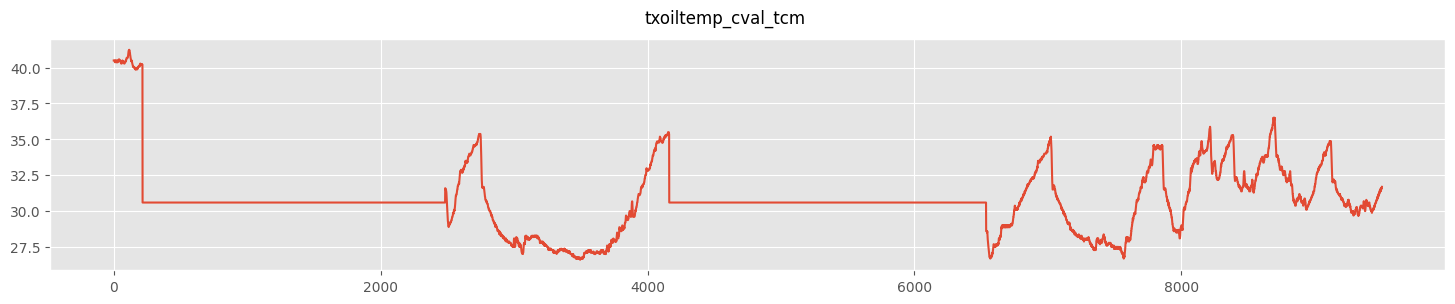

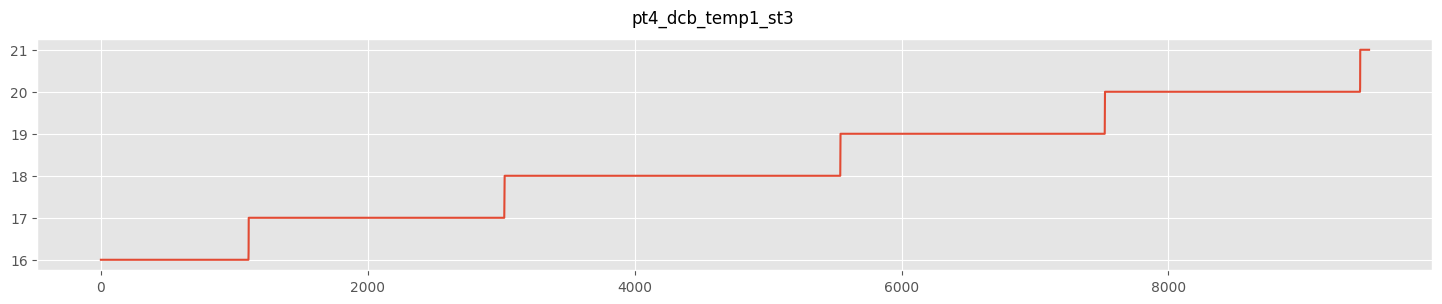

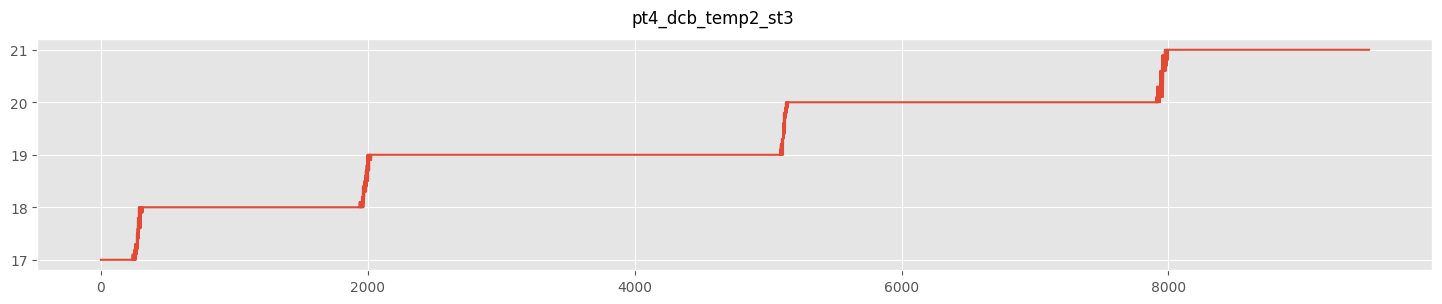

In [43]:
# plot all signals sorted by group
for g in signal_groups.keys():
    i = 0
    for sig in signal_groups[g]:
        if i == 0:
            print(g,":")
            print("-"*150)
            i = 1
        if sig in df.columns:
            _ = df[sig].plot(figsize=(18, 3), subplots=True, title = sig)
            plt.show()

___
___
## 2. Trip Sample Analysis

___
### **Trip Pattern Search**

In [44]:
# find patterns in altitude profile:
m = 500
mp = np.array(stumpy.stump(T.alt, m))
motif_distances, motif_indices = stumpy.motifs(T.alt, mp[:, 0], max_distance=5.0, cutoff=5.0, max_motifs = 1, max_matches = 10)

NameError: name 'stumpy' is not defined

In [45]:
%%skip
# in case no non-zero motifs are found (due to long standing times during trip), the matrix profile will be generated again.
# Howerver this time, only these sections will be considered, that had a non-zero mp-distance-value in the previous step.
if not (motif_distances > 0).any():
    consider = list(np.argwhere(mp[:, 0])[:,0])
    Alt_p = T.alt.iloc[consider]

    mp = np.array(stumpy.stump(Alt_p, m))
    motif_distances, motif_indices = stumpy.motifs(Alt_p, mp[:, 0], max_distance=5.0, cutoff=5.0, max_motifs = 1, max_matches = 10)

else:
    consider = list(range(len(T)))
    Alt_p = T.alt.copy()


Latitude_p = T.lat.iloc[consider]
Longitude_p = T.long.iloc[consider]
Speed_p = T.speed.iloc[consider]   

In [46]:
consider = list(range(len(T)))
Alt_p = T.alt.copy()
Latitude_p = T.lat.iloc[consider]
Longitude_p = T.long.iloc[consider]
Speed_p = T.speed.iloc[consider]   

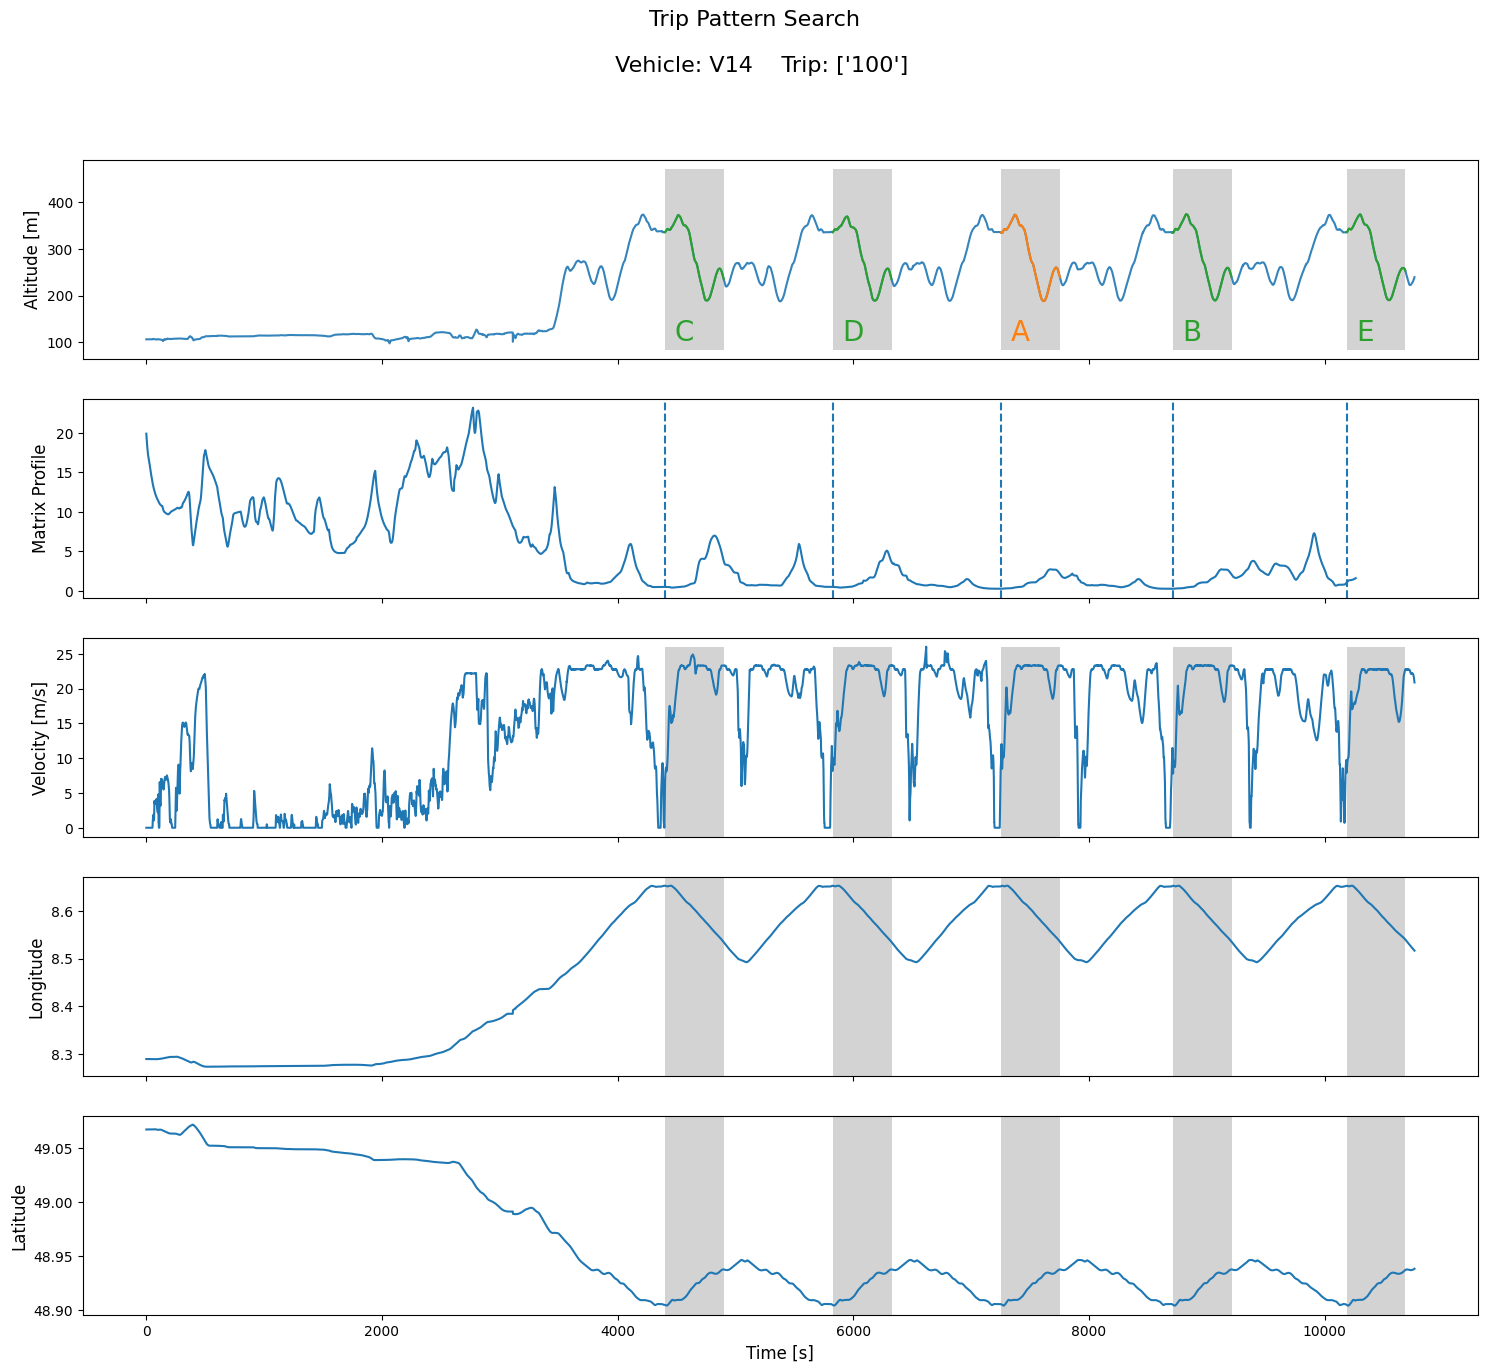

In [47]:
fig, axs = plt.subplots(5, sharex=True,figsize=(18, 15)) #gridspec_kw={'hspace': 0}
plt.suptitle(f'Trip Pattern Search \n\n Vehicle: V{vehicle_selection}    Trip: {trip_selection}', fontsize='16')

axs[0].plot(Alt_p.values,alpha=0.9)
axs[0].set_ylabel('Altitude [m]', fontsize='12')
axs[1].set_ylabel('Matrix Profile', fontsize='12')
axs[1].plot(mp[:, 0])
axs[2].plot(Speed_p.values)
axs[2].set_ylabel('Velocity [m/s]', fontsize='12')
axs[3].plot(Longitude_p.values)
axs[3].set_ylabel('Longitude', fontsize='12')
axs[4].plot(Latitude_p.values)
axs[4].set_ylabel('Latitude', fontsize='12')
axs[4].set_xlabel('Time [s]', fontsize ='12')

alphabet_list = [chr(item) for item in range(ord("A"), ord("Z") + 1)]

axs_limits = []
for i in range(5):
    axs_limits.append(axs[i].get_ylim())

if (motif_distances > 0).any():
    for n in range(len(motif_indices[0])):
        i = motif_indices[0][n]
        if n == 0:
            axs[0].plot(Alt_p.iloc[i:i+m], color='C1')
            axs[0].text(i+m/6, axs_limits[0][0]+20, alphabet_list[n], color='C1', fontsize=20)
        else:
            axs[0].plot(Alt_p.iloc[i:i+m], color='C2')
            axs[0].text(i+m/6, axs_limits[0][0]+20, alphabet_list[n], color='C2', fontsize=20)

        axs[0].add_patch(Rectangle((i, axs_limits[0][0]), m, axs_limits[0][1], facecolor='lightgrey'))
        axs[2].add_patch(Rectangle((i, axs_limits[2][0]), m, axs_limits[2][1], facecolor='lightgrey'))
        axs[3].add_patch(Rectangle((i, axs_limits[3][0]), m, axs_limits[3][1], facecolor='lightgrey'))
        axs[4].add_patch(Rectangle((i, axs_limits[4][0]), m, axs_limits[4][1], facecolor='lightgrey'))

        axs[1].axvline(x=i, linestyle="dashed")
else:
    warnings.warn('No distinctive patterns found.')

plt.show()

___
### **Sample Section**

In [48]:
""" 
VEHICLE: 14, TRIP: 100

continious ascending:   y1, y2 = 3950, 4150
                        y1, y2 = 3450, 3570

continious descending:  y1, y2 = 4680, 4750

repeating sections:     y1, y2 = 3950, 5380     # No. 1
                        y1, y2 = 5380, 6820     # No. 2
                        y1, y2 = 6820, 8270     # No. 3
                        y1, y2 = 8270, 9730     # No. 4
                            
"""

sub_trips = np.array([[3950, 5380], [5380, 6820], [6820, 8270], [8270, 9730]])
st = 0 # select section by index

# sample section (Start/End):
y1, y2 = sub_trips[st][0], sub_trips[st][1]

#y1, y2 = 3950, 4150
y1, y2 = 0, 10000

Plot Section Overview

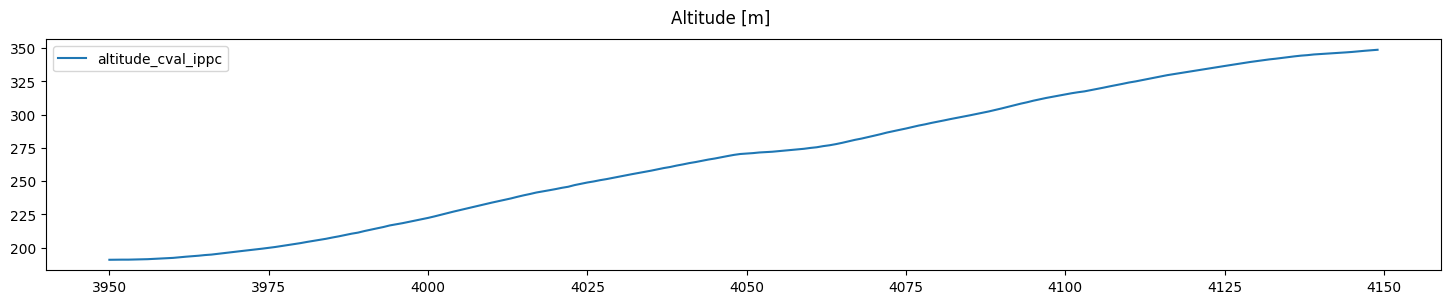

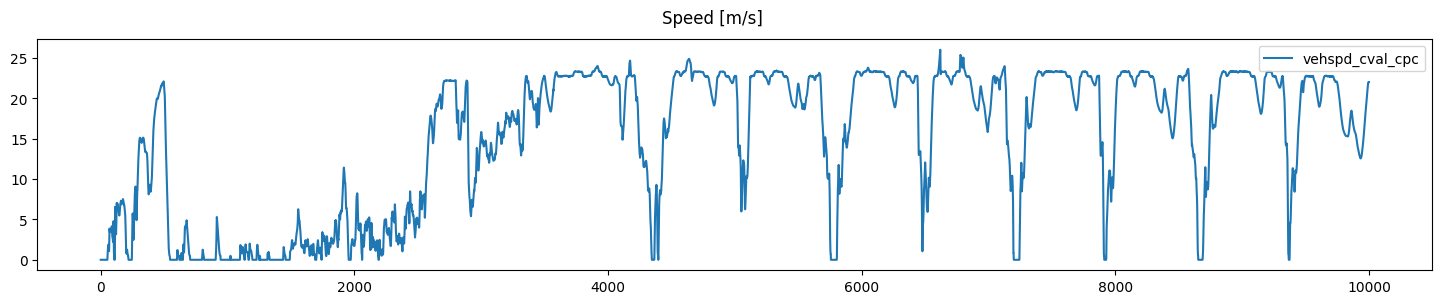

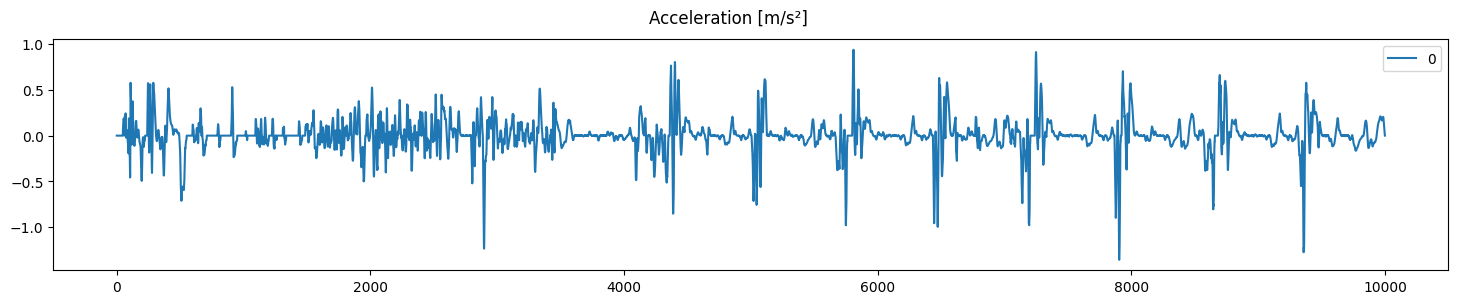

In [60]:
_ = pd.DataFrame(alt)[3950:4150].plot(figsize=(18, 3), subplots=True, title = "Altitude [m]")
_ = pd.DataFrame(speed)[y1:y2].plot(figsize=(18, 3), subplots=True, title ='Speed [m/s]')
_ = pd.DataFrame(accel)[y1:y2].plot(figsize=(18, 3), subplots=True, title ='Acceleration [m/s²]')

Slope and Road Gradient Analysis
___

examine road slope information

In [50]:
print("Section Information:")
print("-"*50)
print("Time Series Length:",y2-y1)
print("Driving Time:",(T.t.iloc[y2]-T.t.iloc[y1]), "[s]")
print("Section Distance:",dist[y2] - dist[y1], "[m]")
print("Avg. Speed:",f'{np.mean(speed[y1:y2]):.3f}', "[m/s]", " / ", f'{np.mean(speed[y1:y2])*3.6:.3f}', "[km/h]")
print("SoC Consumption:",f'{soc[y2] - soc[y1]:.3f}', "[%]")
print("-"*50)

Section Information:
--------------------------------------------------
Time Series Length: 10000
Driving Time: 10000 [s]
Section Distance: 150960.0 [m]
Avg. Speed: 15.105 [m/s]  /  54.377 [km/h]
SoC Consumption: -0.587 [%]
--------------------------------------------------


Calculate the mean slope of section:

In [51]:
alt_delta = alt[y2] - alt[y1]
print('Altitude Delta: ',alt[y2] - alt[y1], "[m]")

dist_delta = (dist[y2] - dist[y1])
print('Distance Delta: ',dist_delta, "[m]")

road_grad_rad = np.arcsin(alt_delta/dist_delta)
horiz_dist = dist_delta * np.cos(road_grad_rad)
print('Mean Slope: ',f'{road_grad_rad:.3f}', "[rad]", " / ", f'{np.rad2deg(road_grad_rad):.3f}',
       "[deg]", " / ", f'{(alt_delta/horiz_dist)*100:.3f}', "[%]")
print("-"*50)

Altitude Delta:  245.45 [m]
Distance Delta:  150960.0 [m]
Mean Slope:  0.002 [rad]  /  0.093 [deg]  /  0.163 [%]
--------------------------------------------------


compare discrete derivative from altitude signal with given signals for road slope/inclination for the observed section: 

In [52]:
alt_diff_int = integrate.trapezoid(np.diff(alt)[y1:y2])
print('Altitude Delta (from "alt_diff"): ',alt_diff_int, "[m]")

Altitude Delta (from "alt_diff"):  245.325 [m]


In [53]:
print('Mean Slope (from "bs_roadincln_cval"): ',f'{np.mean(df.bs_roadincln_cval[y1:y2]):.3f}', "[%]")
print('Mean Slope (from "roadgrad_cval_pt"): ',f'{np.mean(df.roadgrad_cval_pt[y1:y2]):.3f}', "[%]")

Mean Slope (from "bs_roadincln_cval"):  -0.198 [%]
Mean Slope (from "roadgrad_cval_pt"):  0.948 [%]


Recalculate the Altitude delta by integrating the slope signals  
a)  'bs_roadincln_cval'  

In [54]:
roadincl_int = integrate.trapezoid(df.bs_roadincln_cval[y1:y2]/100, dist[y1:y2]) 
print('Altitude Delta (from "roadincl_cval"): ',f'{roadincl_int:.3f}', "[m]")

roadincl_mean_int = np.mean(df.bs_roadincln_cval[y1:y2]/100) * dist_delta
print('Altitude Delta (from "roadincl_mean"): ',f'{roadincl_mean_int:.3f}', "[m]")

Altitude Delta (from "roadincl_cval"):  -439.439 [m]
Altitude Delta (from "roadincl_mean"):  -298.309 [m]


b)    'roadgrad_cval'

In [55]:
roadgrad_cval_int = integrate.trapezoid(df.roadgrad_cval_pt[y1:y2]/100, dist[y1:y2])
print('Altitude Delta (from "roadgrad_cval"): ',f'{roadgrad_cval_int:.3f}', "[m]")

roadgrad_cval_mean = np.mean(np.arctan(df.roadgrad_cval_pt[y1:y2]/100)) * dist_delta
print('Altitude Delta (from "roadgrad_cval_mean"): ',f'{roadgrad_cval_mean:.3f}', "[m]")

Altitude Delta (from "roadgrad_cval"):  1184.835 [m]
Altitude Delta (from "roadgrad_cval_mean"):  1429.470 [m]


___
Range Estimation Model
___

Caculate Momentary Vehicle Consumption in dependence of driving resistances

In [56]:
C = sum(P[y1:y2] * np.ones(y2-y1)) / (3.6 * 10 ** 6)  #[kWh]
Cons_SOC = -100 * C / (V.prm['hv_batt_useable_capacity'] * soh/100)

print("Predicted SoC Consumption:",f'{Cons_SOC:.3f}', "[%]")

NameError: name 'P' is not defined